## Credit card churners

This data set can be found here: https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers?sort=recent-comments

and originally, it stems from here: https://leaps.analyttica.com/

It is about to identify which customers of credit card services leave the service of the bank. Thus, we face the task of a binary prediction problem with the categories 1 (for customers leaving) and 0 (for customers staying). The need of a bank would be in identifying customers with high potential to leave in order to provide them with better services. Besides pure prediction, identifying most relevant features for leaving is of great benefit in order to adjust services to these type of customer groups.

Let us take a look how to master this challenge with a neural network.

In [2]:
import pandas as pd

url = 'https://raw.githubusercontent.com/RalfKellner/dlta_repo/master/bank_churners.csv'
churners_df = pd.read_csv(url)
# we drop the client number and the last two numbers which seem to stem from some different kind of modeling - naive Bayes
churners_df = churners_df.drop(['CLIENTNUM',
                  'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                  'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis = 1)

churners_df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


We have a mix of categorical and numerical feature variables with "Attrition_Flag" being the target variable. Furthermore, there are no missing values in this data set.

In [3]:
churners_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

Below, we see the fraction of attrited customers which is 16.1%. This adds another challenge to the model because the target variable is rather unbalanced. While we are most interested in this category, the model will be trained with a majority of data points for the category of customers staying. Later, we try to activaly attack this problem by creating synthetic data for the attrited customers category using SMOTE-NC.

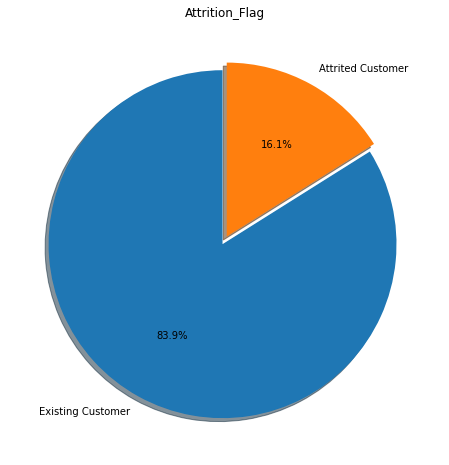

In [4]:
import matplotlib.pylab as plt

# function for generating a pie chart
def pie_chart(df, var_name, ax = None, **plt_kwargs):
    
    # this is just some helper to make sure the graph is plotted even though no figure with axes has been generated before
    if ax is None:
        ax = plt.gca()
    
    # number of categorical occurences in per cent
    fracs = df[var_name].value_counts(normalize = True) * 100

    # this is the actual pie chart
    ax.pie(x = fracs.values,
        labels = list(fracs.keys()),
        startangle = 90,
        #colors = some_colors[:len(fracs.values)],
        autopct = '%2.1f%%',
        explode = [0.025] * len(fracs.values),
        shadow = True)
    ax.set_title(var_name)
    return(ax)

  
fig, ax = plt.subplots(figsize = (8, 8))
pie_chart(churners_df, 'Attrition_Flag', ax = ax)

Let us start with some visual inspections. First for categorical feature variables. I like to generate fractions for the category of interest and each categorical feature in order to examine if there are major inbalances for each category. If so, this would indicate that this feature may be good to differentiate between attrited and existing customers. For instance, the figures below indicate that platinum card customers with either a rather high or low income tend to leave the credit card service more easily.

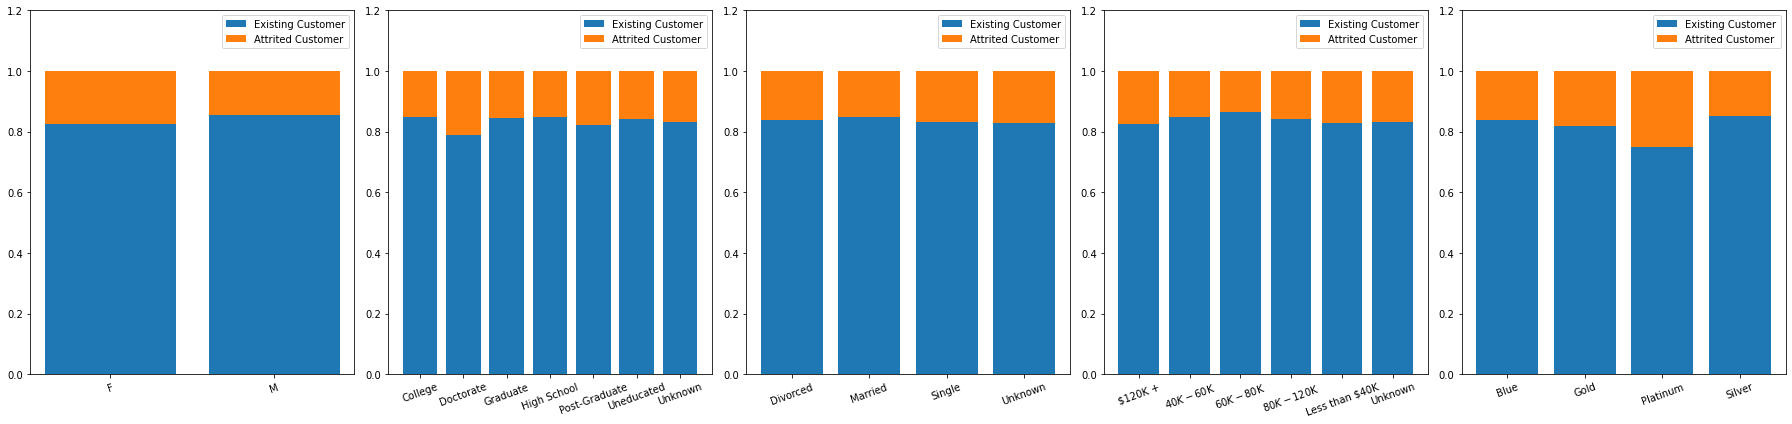

In [5]:
import numpy as np

# function for generating stacked bar charts
def sbar_chart(df, x_var, cat_var, ax = None, **plt_kwargs):
    
    # this is just some helper to make sure the graph is plotted even though no figure with axes has been generated before
    if ax is None:
        ax = plt.gca()

    x = list(df[x_var].unique())
    y_cat = list(df[cat_var].unique())

    X = []
    Y = []

    x_tmp = list(df[df[cat_var] == y_cat[0]][[x_var]].groupby(x_var).size().index)
    X.append(x_tmp)
    y_tmp = list(df[df[cat_var] == y_cat[0]][[x_var]].groupby(x_var).size().values)
    Y.append(y_tmp)

    for i in range(1, len(y_cat)):
      x_tmp = list(df[df[cat_var] == y_cat[i]][[x_var]].groupby(x_var).size().index)
      X.append(x_tmp)
      y_tmp = list(df[df[cat_var] == y_cat[i]][[x_var]].groupby(x_var).size().values)
      Y.append(y_tmp)
      
    Y_out = np.array(Y) / np.sum(np.array(Y), axis = 0)

    x, y = X[0], Y_out[0]
    ax.bar(x, y)
    y_bottom = np.array(y)

    for i in range(1, len(y_cat)):
      x, y = X[i], Y_out[i]
      ax.bar(x, y, bottom = y_bottom)
      y_bottom += np.array(y)
    ax.legend(y_cat)
    ax.set_xticklabels(x, rotation = 20)
    ax.set_ylim(0, 1.2)
    return(ax)



object_variables = churners_df.columns[churners_df.dtypes == 'object']
object_variables = object_variables[1:]

fig, axs = plt.subplots(1, 5, figsize = (25, 6))

for i, ov in enumerate(object_variables):
  sbar_chart(churners_df, ov, 'Attrition_Flag', ax = axs[i])

fig.tight_layout()

For numerical feature, I like to compare empirical distributions for attrited and existing customers. Only if we observe differences here, the feature might be suited for identifying attrited customers on a stand alone basis. This seems to be most pronounced for features such as "Total_Relationship_Count, Contacts_Count_12_mon, Total_Revolving_Bal, Total_Trans_Amt, Total_Trans_Ct, Avg_Utilization_Ratio".

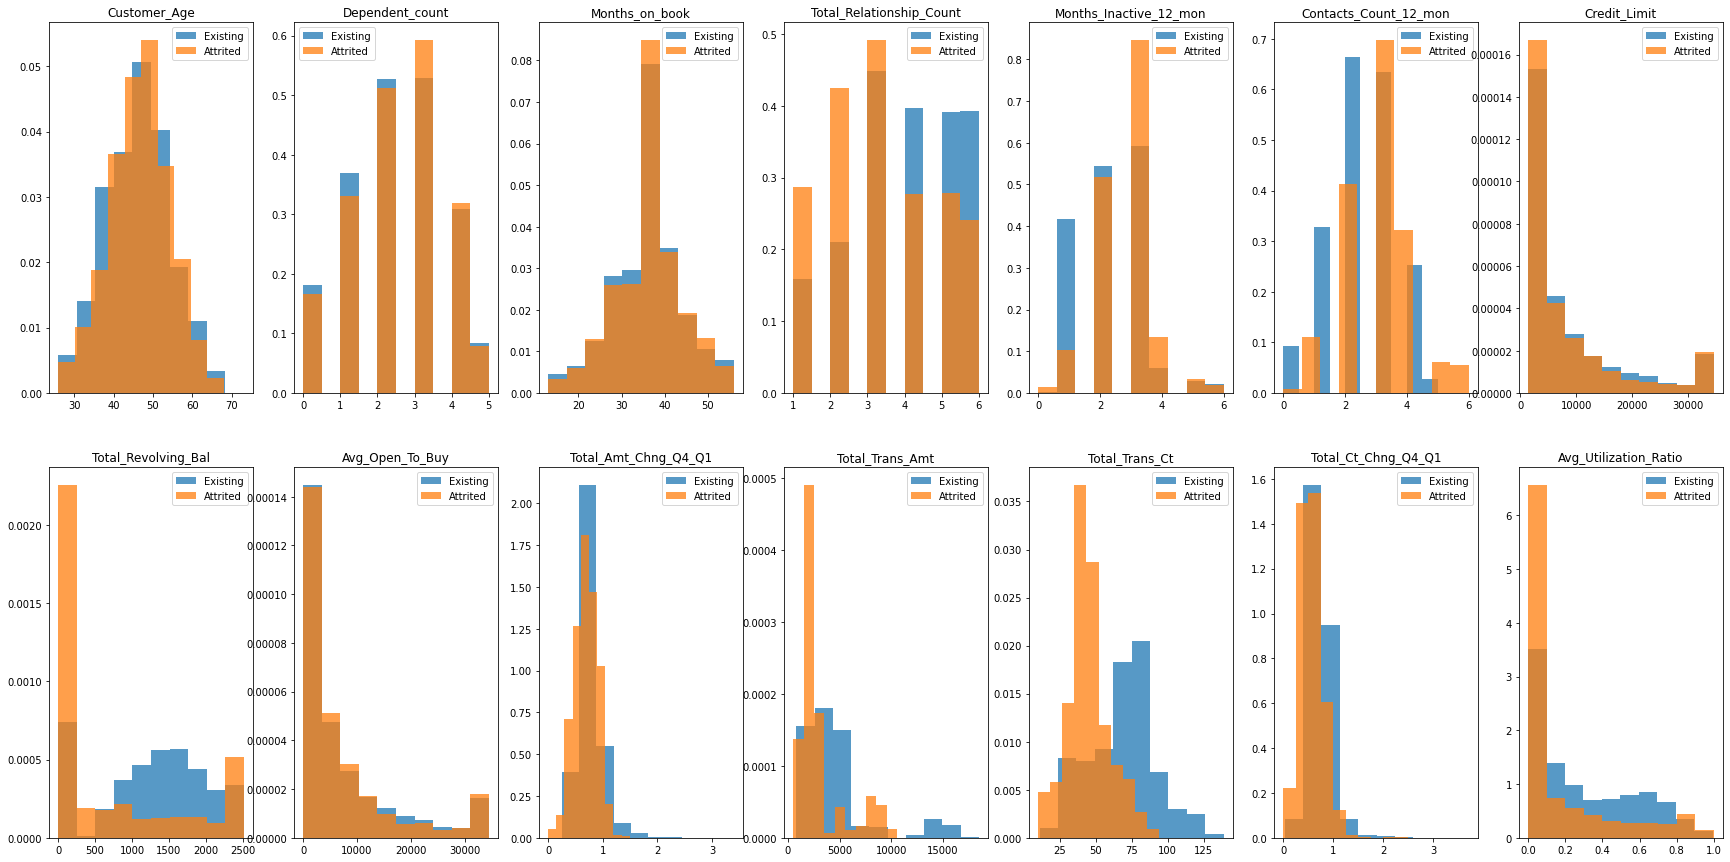

In [6]:
import matplotlib.pylab as plt

# now let us take a look at numerical feature variables
numerical_variables = churners_df.columns[churners_df.dtypes != 'object']

# regarding numerical features and categorical target variables, I find it useful to generate histograms per category
# this gives us an impression of the distributional shape 
# furthermore, if distributions are different per target class, it may be a helpful feature for differentiating between the target categories

def own_hist(df, var_name, ax = None, **plt_kwargs):
  if ax is None:
    ax = plt.gca()

  ax.hist(df[var_name][df['Attrition_Flag'] == 'Existing Customer'], density = True, alpha = 0.75, label = 'Existing')
  ax.hist(df[var_name][df['Attrition_Flag'] == 'Attrited Customer'], density = True, alpha = 0.75, label = 'Attrited')
  ax.legend()
  ax.set_title(var_name)
  
  return ax

fig, axes = plt.subplots(2, 7, figsize = (30, 15))
counter = 0
for i in range(2):
  for j in range(7):
    own_hist(churners_df, numerical_variables[counter], ax = axes[i,j])
    counter += 1

To use categorical features, I one-hot-encode them together with a 0-1 numerical encoding of the target variable "Attrition_Flag".

In [7]:
for o in object_variables:
  # one-hot-encode categorical features and drop the column, I also remove the first category which serves as a dummy category
  churners_df = pd.concat([churners_df, pd.get_dummies(churners_df[o]).iloc[:, :-1]], axis = 1).drop([o], axis = 1)

# make target variable
churners_df['Attrition_Flag'] = churners_df['Attrition_Flag'].replace({'Attrited Customer':1,'Existing Customer':0})
churners_df.head()

,Attrition_Flag,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Married,Single,$120K +,$40K - $60K,$60K - $80K,$80K - $120K,Less than $40K,Blue,Gold,Platinum
0,0,45,3,39,5,1,3,12691.0,777,11914.0,...,1,0,0,0,1,0,0,1,0,0
1,0,49,5,44,6,1,2,8256.0,864,7392.0,...,0,1,0,0,0,0,1,1,0,0
2,0,51,3,36,4,1,0,3418.0,0,3418.0,...,1,0,0,0,0,1,0,1,0,0
3,0,40,4,34,3,4,1,3313.0,2517,796.0,...,0,0,0,0,0,0,1,1,0,0
4,0,40,3,21,5,1,0,4716.0,0,4716.0,...,1,0,0,0,1,0,0,1,0,0


A quick outlier check for the overall data.

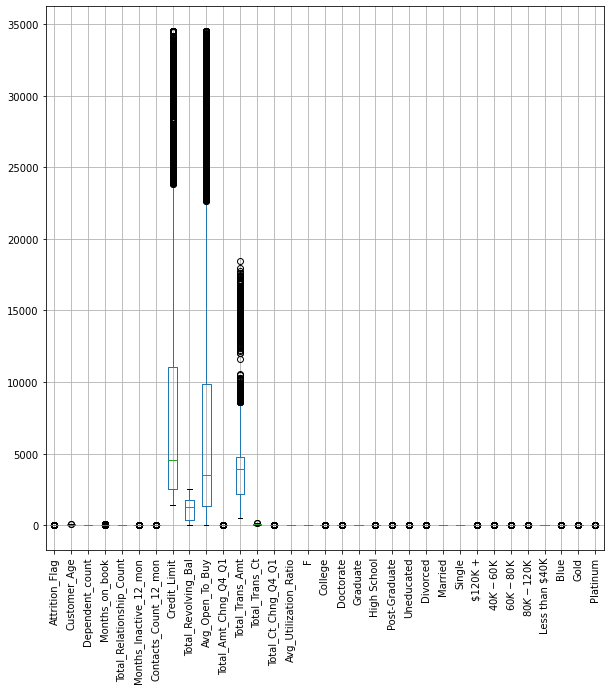

In [8]:
churners_df.boxplot(figsize = (10, 10), rot = 90)

Next, let us split and standardize data for reasons of comparability and for usage of neural networks which need normalized input data.

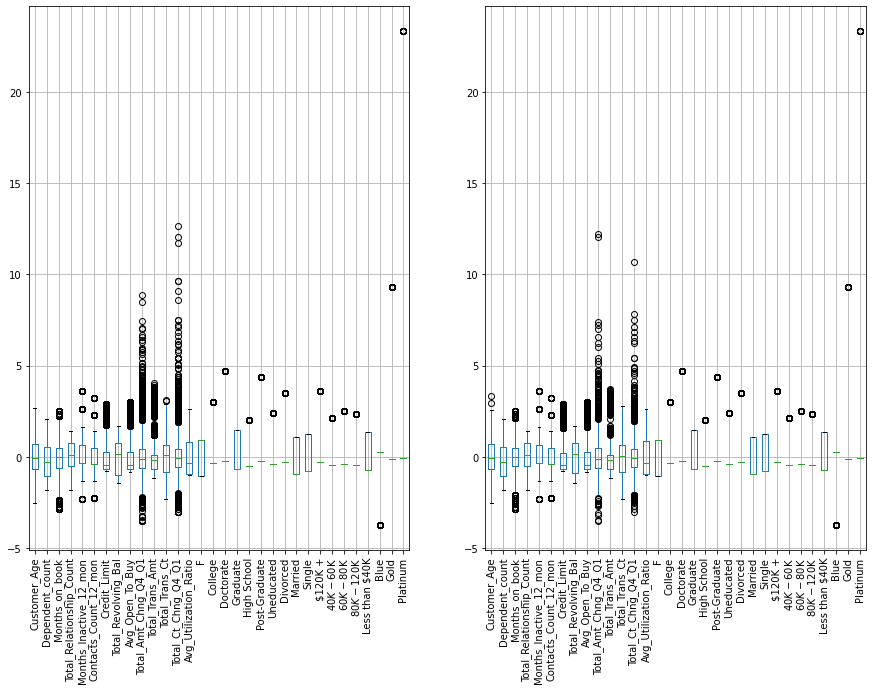

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# split the data randomly into 70% training and 30% test data 
train_df, test_df = train_test_split(churners_df, test_size = 0.3, random_state = 42)

# training and test data
X_train, X_test = train_df.drop(['Attrition_Flag'], axis = 1), test_df.drop(['Attrition_Flag'], axis = 1)
y_train, y_test = train_df['Attrition_Flag'].values, test_df['Attrition_Flag'].values 

# we use standard scaling, alternatives are, e.g., min-max-scaling or quantile-transformers
scaler = StandardScaler()
scaler.fit(X_train)

# neural networks only need standardized feature data
X_train_s, X_test_s = scaler.transform(X_train), scaler.transform(X_test)

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
pd.DataFrame(data = X_train_s, columns = X_train.columns).boxplot(figsize = (10, 10), rot = 90, ax = axs[0])
pd.DataFrame(data = X_test_s, columns = X_test.columns).boxplot(figsize = (10, 10), rot = 90, ax = axs[1])

First, we take a look at the results of the logistic regression model which serves as as benchmark. In order to evaluate model performance, I like to take a look at precision, recall and the F1 score. In my opinion this is preferable to just looking at accuracy because most important for our model is to generate good predictions for the relevant instance - attrited customer. 

Precision is the ability of the model to make correct positive predictions. It is the fraction of positives (real customer attritions) among predicted positives (predicted customer attritions). TP / (TP + FP).

Recall is the ability to identify true positive instances. It is the fraction of positive predictions (predict customer attrition) in relation to all positives (real customer attrition). TP /(TP + FN)

The F1 score is a harmonic mean of both scores. A good model for the relevant category should have good values for precision as well as the recall. For instance, we may generate a recall of 1 by predicting only postives, however, this will lead to a large amount of false positives, thus, a low value for the precision. The consequence would be that we approach a lot of customers whith no will to leave the company. In real life situations this would cause a large amount of unnecessary costs for the company.

The results for the logistic regression model below show that the model tends to predict too little positives as the recall is rather low. This also leads to a lower amount of false positives which increases precision. Overall an imbalance between the two mistakes FN and FP exists.

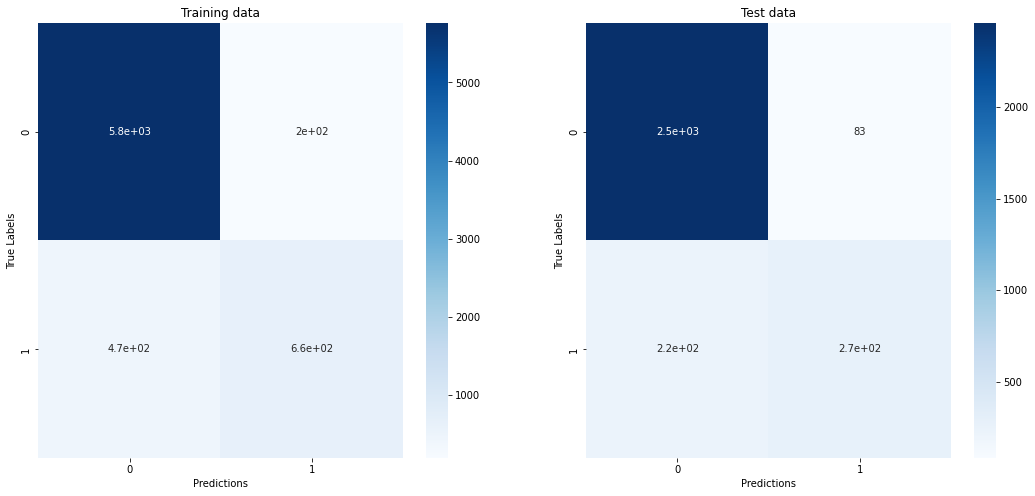

Training precision score: 0.7715
Test precision score: 0.7655
Training recall score: 0.5880
Test recall score: 0.5464
Training F1 score: 0.6673
Test F1 score: 0.6376


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pylab as plt

log_reg = LogisticRegression()
log_reg.fit(X_train_s, y_train)

y_train_pred = log_reg.predict(X_train_s)
y_test_pred = log_reg.predict(X_test_s) 


# let us take a look at the confusion matrix, predictions are 1 if the predicted proability for class 1 is higher than 0.5
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

train_cm = confusion_matrix(y_train, y_train_pred)
sn.heatmap(train_cm, annot = True, cmap = 'Blues', ax = axs[0])

axs[0].set_xlabel('Predictions')
axs[0].set_ylabel('True Labels')
axs[0].set_title('Training data')

test_cm = confusion_matrix(y_test, y_test_pred)
sn.heatmap(test_cm, annot = True, cmap='Blues', ax = axs[1])

axs[1].set_xlabel('Predictions')
axs[1].set_ylabel('True Labels')
axs[1].set_title('Test data')

plt.show()

print(f'Training precision score: {precision_score(y_train, y_train_pred):.4f}')
print(f'Test precision score: {precision_score(y_test, y_test_pred):.4f}')
print(f'Training recall score: {recall_score(y_train, y_train_pred):.4f}')
print(f'Test recall score: {recall_score(y_test, y_test_pred):.4f}')
print(f'Training F1 score: {f1_score(y_train, y_train_pred):.4f}')
print(f'Test F1 score: {f1_score(y_test, y_test_pred):.4f}')

Let us quickly take a look at the regression coefficients. As data is standardized, higher values indicate higher importance of each feature. The results are in line with visual inspections.

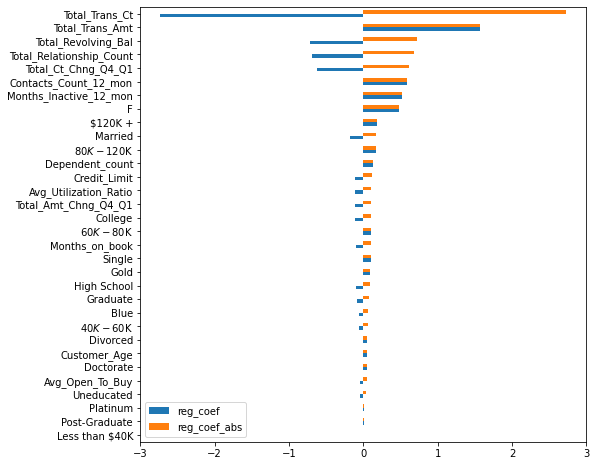

In [11]:
log_reg_coef = pd.DataFrame(data = log_reg.coef_.flatten(), index = X_train.columns, columns = ['reg_coef'])
log_reg_coef.loc[:, 'reg_coef_abs'] = log_reg_coef.reg_coef.abs()
log_reg_coef.sort_values(by = 'reg_coef_abs', ascending = True, inplace = True)
log_reg_coef.plot.barh(figsize = (8, 8))

Next, I fit a neural network, hyperparameter choices are arbitrary, however, I added the dropout after watching a tendency for overfitting the data.

Epoch 1/50
222/222 [==============================] - 2s 4ms/step - loss: 0.5411 - val_loss: 0.3611
Epoch 2/50
222/222 [==============================] - 1s 3ms/step - loss: 0.3263 - val_loss: 0.2732
Epoch 3/50
222/222 [==============================] - 1s 3ms/step - loss: 0.2846 - val_loss: 0.2624
Epoch 4/50
222/222 [==============================] - 1s 3ms/step - loss: 0.2681 - val_loss: 0.2559
Epoch 5/50
222/222 [==============================] - 1s 3ms/step - loss: 0.2626 - val_loss: 0.2516
Epoch 6/50
222/222 [==============================] - 1s 4ms/step - loss: 0.2507 - val_loss: 0.2488
Epoch 7/50
222/222 [==============================] - 1s 3ms/step - loss: 0.2571 - val_loss: 0.2470
Epoch 8/50
222/222 [==============================] - 1s 3ms/step - loss: 0.2528 - val_loss: 0.2448
Epoch 9/50
222/222 [==============================] - 1s 3ms/step - loss: 0.2539 - val_loss: 0.2422
Epoch 10/50
222/222 [==============================] - 1s 3ms/step - loss: 0.2472 - val_loss: 0.2416

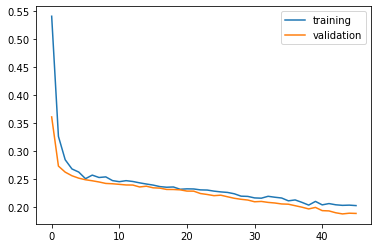

In [12]:
import tensorflow as tf
import matplotlib.pylab as plt

# define a neural network using the keras sequential api
my_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (X_train_s.shape[1])),
    tf.keras.layers.Dense(
      20, activation = 'tanh', name = 'hidden_layer'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(10, activation = 'tanh', name = 'hidden_layer2'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# alternative choices for the loss would be, e.g., the mean absolute error or the huber loss
my_model.compile(loss = 'binary_crossentropy', optimizer = 'Adam')
my_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2)
history = my_model.fit(X_train_s, y_train, epochs = 50, validation_data = (X_test_s, y_test), callbacks = [my_callback])

# we can visualize the evaluation of the loss during training
plt.plot(history.history['loss'], label = 'training')
plt.plot(history.history['val_loss'], label = 'validation')
plt.legend()
plt.show()

95/95 [==============================] - 0s 2ms/step


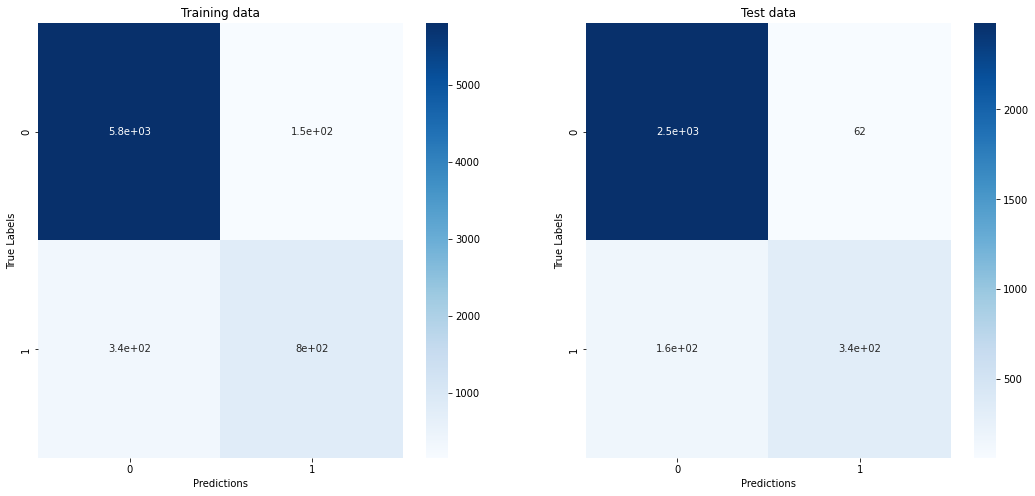

Training precision score: 0.8386
Test precision score: 0.8438
Training recall score: 0.7029
Test recall score: 0.6754
Training F1 score: 0.7648
Test F1 score: 0.7503


In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pylab as plt

y_train_pred, y_test_pred = (my_model.predict(X_train_s).flatten() > 0.5)*1, (my_model.predict(X_test_s).flatten() > 0.5) * 1

# let us take a look at the confusion matrix, predictions are 1 if the predicted proability for class 1 is higher than 0.5
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

train_cm = confusion_matrix(y_train, y_train_pred)
sn.heatmap(train_cm, annot = True, cmap='Blues', ax = axs[0])

axs[0].set_xlabel('Predictions')
axs[0].set_ylabel('True Labels')
axs[0].set_title('Training data')

test_cm = confusion_matrix(y_test, y_test_pred)
sn.heatmap(test_cm, annot = True, cmap='Blues', ax = axs[1])

axs[1].set_xlabel('Predictions')
axs[1].set_ylabel('True Labels')
axs[1].set_title('Test data')

plt.show()

print(f'Training precision score: {precision_score(y_train, y_train_pred):.4f}')
print(f'Test precision score: {precision_score(y_test, y_test_pred):.4f}')
print(f'Training recall score: {recall_score(y_train, y_train_pred):.4f}')
print(f'Test recall score: {recall_score(y_test, y_test_pred):.4f}')
print(f'Training F1 score: {f1_score(y_train, y_train_pred):.4f}')
print(f'Test F1 score: {f1_score(y_test, y_test_pred):.4f}')

## Feature importance

Last but not least, let us analyze which features are most important for our model. We follow a sensitivity based approach which determines partial derivatives of the prediction with respect a marginal change in each feature variable. To estimate average importance, we get the square root of squared partial derivatives. In order to examine the direction of the feature variable, we estimate if the feature has on average a positive or negative impact on predictions. Below we find similar results as for the logistic regression model.

In summary, the bank should watch out for customers whose total transaction count is low in combination with higher transactions. While this seems intuitive and less spectacular, it is good to know that it is enough to monitor these variables and that other variables such as sociographic information is rather negligible.

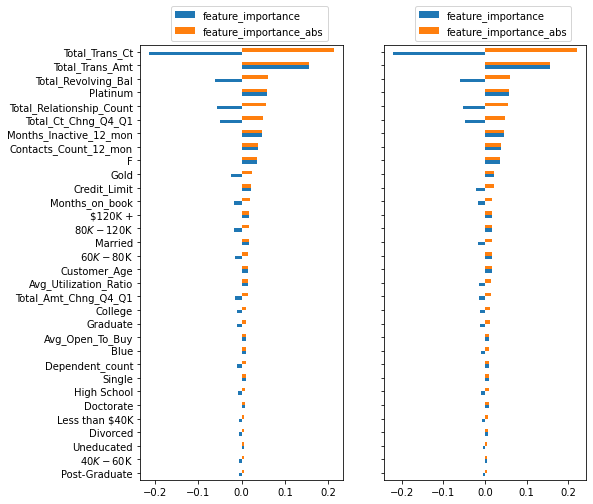

In [14]:
import numpy as np

fig, axs = plt.subplots(1, 2, figsize = (8, 8), sharey = True)

X_train_tensor = tf.convert_to_tensor(X_train_s)
X_test_tensor = tf.convert_to_tensor(X_test_s)

with tf.GradientTape() as tape:
  tape.watch(X_train_tensor)
  y_train_pred = my_model(X_train_tensor)

grads = tape.gradient(y_train_pred, X_train_tensor).numpy()

feature_importance = np.sign(np.mean(grads, axis = 0)) * np.sqrt(np.mean(grads**2, axis = 0))
feature_importance_scaled = feature_importance / np.sum(np.abs(feature_importance))
feature_importance_df = pd.DataFrame(index = X_train.columns, data = feature_importance_scaled, columns = ['feature_importance'])
feature_importance_df.loc[:, 'feature_importance_abs'] = feature_importance_df.feature_importance.abs()
feature_importance_df.sort_values(by = 'feature_importance_abs', ascending = True, inplace = True)
feature_importance_df.plot.barh(ax = axs[0])

with tf.GradientTape() as tape:
  tape.watch(X_test_tensor)
  y_test_pred = my_model(X_test_tensor)

grads = tape.gradient(y_test_pred, X_test_tensor).numpy()

feature_importance = np.sign(np.mean(grads, axis = 0)) * np.sqrt(np.mean(grads**2, axis = 0))
feature_importance_scaled = feature_importance / np.sum(np.abs(feature_importance))
feature_importance_df = pd.DataFrame(index = X_train.columns, data = feature_importance_scaled, columns = ['feature_importance'])
feature_importance_df.loc[:, 'feature_importance_abs'] = feature_importance_df.feature_importance.abs()
feature_importance_df.sort_values(by = 'feature_importance_abs', ascending = True, inplace = True)
feature_importance_df.plot.barh(ax = axs[1])


axs[0].legend(bbox_to_anchor=(0.95, 1.1))
axs[1].legend(bbox_to_anchor=(0.95, 1.1))

In the next step, I try to optimize hyperparameters using optuna. First without cross fold validation, second, with cross fold validation within the hyperparameter optimization routine.

In [15]:
! pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 6.1 MB/s 
     |████████████████████████████████| 81 kB 11.8 MB/s 
     |████████████████████████████████| 209 kB 52.9 MB/s 
     |████████████████████████████████| 78 kB 8.1 MB/s 
     |████████████████████████████████| 112 kB 53.6 MB/s 
     |████████████████████████████████| 147 kB 52.6 MB/s 
     |████████████████████████████████| 50 kB 7.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=e82135cbc96a5085029caafe68403b0e28866d9810a12af30f70945a9748b10e
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [16]:
import optuna
import tensorflow as tf
from sklearn.metrics import f1_score, precision_score, recall_score


# define an objective function whose output is optimized with respect to trial instances
def objective(trial):
  
  # check 1 up to 3 hidden layers 
  n_layers = trial.suggest_int('n_layers', 1, 3)

  # initialize an "empty" network
  my_model = tf.keras.Sequential()
  # we define a separate input layer which specifies the shape of feature variables
  my_model.add(tf.keras.layers.InputLayer(input_shape = X_train.shape[1]))

  # for each hidden layer
  for i in range(n_layers):
    # we search for an optimal amount of hidden neurons
    num_hidden = trial.suggest_int(f'n_units_l{i}', 4, 128, log=True)
    # and among the activation functions defined below
    a_fun = trial.suggest_categorical(f'a_fun_l{i}', ['tanh', 'sigmoid', 'relu'])  
    # add this hidden layer
    my_model.add(tf.keras.layers.Dense(num_hidden, activation = a_fun))
    # add dropout against overfitting
    dropout_rate = trial.suggest_float(f'drate_l{i}', 0.1, 0.5)
    my_model.add(tf.keras.layers.Dropout(dropout_rate))

  # in the end add an output 
  my_model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

  # two optimizers
  optim = trial.suggest_categorical(f'optimizer', ['Adam', 'RMSprop'])

  # compile the model
  my_model.compile(loss = 'binary_crossentropy', optimizer = optim)
  
  # different callback parameters are available, we try the number of steps to wait for improvement of validation data
  # once the loss value for validation data does not improve for the number of patience steps the network optimization stops
  callback_patience = trial.suggest_int(f'callback_patience', 1, 5)
  my_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = callback_patience)

  # if the loss for validation data always improves, the model is trained until the maximum number of epochs is reached
  n_epochs = trial.suggest_int(f'training_epochs', 10, 100)
  my_model.fit(X_train_s, y_train, epochs = n_epochs, validation_data = (X_test_s, y_test), callbacks = [my_callback], verbose = 0)

  # we aim to maximize validation/test data's R^2 which we output for the objective 
  y_test_pred = (my_model.predict(X_test_s).flatten() > 0.5) * 1
  f1_test = f1_score(y_test, y_test_pred)

  return f1_test

# create an optim study instance
study = optuna.create_study(direction='maximize')
# optimize hyperparameters for n_trials 
study.optimize(objective, n_trials=20)

[I 2022-11-28 08:52:51,332] A new study created in memory with name: no-name-cbd210ac-a163-4cd0-a47e-5d04556bc972


95/95 [==============================] - 1s 5ms/step


[I 2022-11-28 08:53:17,268] Trial 0 finished with value: 0.0 and parameters: {'n_layers': 3, 'n_units_l0': 5, 'a_fun_l0': 'tanh', 'drate_l0': 0.22066334066705748, 'n_units_l1': 8, 'a_fun_l1': 'sigmoid', 'drate_l1': 0.29503945775201146, 'n_units_l2': 4, 'a_fun_l2': 'relu', 'drate_l2': 0.48195919352755134, 'optimizer': 'RMSprop', 'callback_patience': 2, 'training_epochs': 63}. Best is trial 0 with value: 0.0.


95/95 [==============================] - 0s 2ms/step


[I 2022-11-28 08:54:01,155] Trial 1 finished with value: 0.7579408543263966 and parameters: {'n_layers': 1, 'n_units_l0': 40, 'a_fun_l0': 'relu', 'drate_l0': 0.3284290541021272, 'optimizer': 'Adam', 'callback_patience': 5, 'training_epochs': 31}. Best is trial 1 with value: 0.7579408543263966.


95/95 [==============================] - 0s 1ms/step


[I 2022-11-28 08:54:22,989] Trial 2 finished with value: 0.7314285714285715 and parameters: {'n_layers': 1, 'n_units_l0': 43, 'a_fun_l0': 'tanh', 'drate_l0': 0.16124834977036492, 'optimizer': 'RMSprop', 'callback_patience': 2, 'training_epochs': 63}. Best is trial 1 with value: 0.7579408543263966.


95/95 [==============================] - 0s 1ms/step


[I 2022-11-28 08:54:56,061] Trial 3 finished with value: 0.7446083995459705 and parameters: {'n_layers': 1, 'n_units_l0': 63, 'a_fun_l0': 'tanh', 'drate_l0': 0.3355800247213353, 'optimizer': 'Adam', 'callback_patience': 2, 'training_epochs': 64}. Best is trial 1 with value: 0.7579408543263966.


95/95 [==============================] - 0s 2ms/step


[I 2022-11-28 08:55:09,099] Trial 4 finished with value: 0.6058394160583941 and parameters: {'n_layers': 3, 'n_units_l0': 4, 'a_fun_l0': 'tanh', 'drate_l0': 0.4341815141315899, 'n_units_l1': 14, 'a_fun_l1': 'relu', 'drate_l1': 0.3358927695008036, 'n_units_l2': 5, 'a_fun_l2': 'sigmoid', 'drate_l2': 0.4171846971768406, 'optimizer': 'RMSprop', 'callback_patience': 1, 'training_epochs': 32}. Best is trial 1 with value: 0.7579408543263966.


95/95 [==============================] - 0s 1ms/step


[I 2022-11-28 08:55:15,454] Trial 5 finished with value: 0.6237864077669903 and parameters: {'n_layers': 2, 'n_units_l0': 7, 'a_fun_l0': 'tanh', 'drate_l0': 0.2568851281941752, 'n_units_l1': 83, 'a_fun_l1': 'sigmoid', 'drate_l1': 0.4388954036850191, 'optimizer': 'RMSprop', 'callback_patience': 1, 'training_epochs': 44}. Best is trial 1 with value: 0.7579408543263966.


95/95 [==============================] - 0s 1ms/step


[I 2022-11-28 08:55:27,706] Trial 6 finished with value: 0.6611177170035671 and parameters: {'n_layers': 3, 'n_units_l0': 75, 'a_fun_l0': 'sigmoid', 'drate_l0': 0.4182298992335475, 'n_units_l1': 40, 'a_fun_l1': 'relu', 'drate_l1': 0.12241863682661674, 'n_units_l2': 31, 'a_fun_l2': 'tanh', 'drate_l2': 0.14876930421305323, 'optimizer': 'RMSprop', 'callback_patience': 2, 'training_epochs': 98}. Best is trial 1 with value: 0.7579408543263966.


95/95 [==============================] - 0s 1ms/step


[I 2022-11-28 08:55:30,426] Trial 7 finished with value: 0.5266106442577031 and parameters: {'n_layers': 2, 'n_units_l0': 44, 'a_fun_l0': 'sigmoid', 'drate_l0': 0.25670241150190054, 'n_units_l1': 36, 'a_fun_l1': 'tanh', 'drate_l1': 0.34153058215556864, 'optimizer': 'Adam', 'callback_patience': 1, 'training_epochs': 51}. Best is trial 1 with value: 0.7579408543263966.


95/95 [==============================] - 0s 1ms/step


[I 2022-11-28 08:55:43,211] Trial 8 finished with value: 0.6301369863013699 and parameters: {'n_layers': 2, 'n_units_l0': 121, 'a_fun_l0': 'sigmoid', 'drate_l0': 0.36077212957897753, 'n_units_l1': 4, 'a_fun_l1': 'tanh', 'drate_l1': 0.453233515895178, 'optimizer': 'RMSprop', 'callback_patience': 3, 'training_epochs': 66}. Best is trial 1 with value: 0.7579408543263966.


95/95 [==============================] - 0s 2ms/step


[I 2022-11-28 08:56:05,089] Trial 9 finished with value: 0.5439330543933054 and parameters: {'n_layers': 3, 'n_units_l0': 5, 'a_fun_l0': 'sigmoid', 'drate_l0': 0.49869699024613745, 'n_units_l1': 110, 'a_fun_l1': 'sigmoid', 'drate_l1': 0.13447068928337066, 'n_units_l2': 12, 'a_fun_l2': 'tanh', 'drate_l2': 0.3535563919343597, 'optimizer': 'RMSprop', 'callback_patience': 3, 'training_epochs': 75}. Best is trial 1 with value: 0.7579408543263966.


95/95 [==============================] - 0s 2ms/step


[I 2022-11-28 08:56:12,784] Trial 10 finished with value: 0.7027649769585254 and parameters: {'n_layers': 1, 'n_units_l0': 16, 'a_fun_l0': 'relu', 'drate_l0': 0.12222357186590349, 'optimizer': 'Adam', 'callback_patience': 5, 'training_epochs': 12}. Best is trial 1 with value: 0.7579408543263966.


95/95 [==============================] - 0s 1ms/step


[I 2022-11-28 08:56:34,247] Trial 11 finished with value: 0.7629547960308711 and parameters: {'n_layers': 1, 'n_units_l0': 23, 'a_fun_l0': 'relu', 'drate_l0': 0.34125563319280955, 'optimizer': 'Adam', 'callback_patience': 5, 'training_epochs': 30}. Best is trial 11 with value: 0.7629547960308711.


95/95 [==============================] - 0s 1ms/step


[I 2022-11-28 08:56:55,635] Trial 12 finished with value: 0.7440811724915445 and parameters: {'n_layers': 1, 'n_units_l0': 21, 'a_fun_l0': 'relu', 'drate_l0': 0.31216405129147956, 'optimizer': 'Adam', 'callback_patience': 5, 'training_epochs': 24}. Best is trial 11 with value: 0.7629547960308711.


95/95 [==============================] - 0s 1ms/step


[I 2022-11-28 08:57:17,646] Trial 13 finished with value: 0.7274826789838338 and parameters: {'n_layers': 1, 'n_units_l0': 11, 'a_fun_l0': 'relu', 'drate_l0': 0.38468155254522274, 'optimizer': 'Adam', 'callback_patience': 4, 'training_epochs': 35}. Best is trial 11 with value: 0.7629547960308711.


95/95 [==============================] - 0s 2ms/step


[I 2022-11-28 08:57:25,232] Trial 14 finished with value: 0.7209039548022599 and parameters: {'n_layers': 1, 'n_units_l0': 31, 'a_fun_l0': 'relu', 'drate_l0': 0.2899282855107698, 'optimizer': 'Adam', 'callback_patience': 4, 'training_epochs': 12}. Best is trial 11 with value: 0.7629547960308711.


95/95 [==============================] - 0s 2ms/step


[I 2022-11-28 08:57:39,738] Trial 15 finished with value: 0.6872770511296076 and parameters: {'n_layers': 2, 'n_units_l0': 15, 'a_fun_l0': 'relu', 'drate_l0': 0.46535757090682867, 'n_units_l1': 4, 'a_fun_l1': 'relu', 'drate_l1': 0.22669768969648624, 'optimizer': 'Adam', 'callback_patience': 4, 'training_epochs': 25}. Best is trial 11 with value: 0.7629547960308711.


95/95 [==============================] - 0s 1ms/step


[I 2022-11-28 08:58:02,914] Trial 16 finished with value: 0.7527593818984548 and parameters: {'n_layers': 1, 'n_units_l0': 29, 'a_fun_l0': 'relu', 'drate_l0': 0.3799662890005171, 'optimizer': 'Adam', 'callback_patience': 5, 'training_epochs': 43}. Best is trial 11 with value: 0.7629547960308711.


95/95 [==============================] - 0s 1ms/step


[I 2022-11-28 08:58:14,478] Trial 17 finished with value: 0.7136150234741784 and parameters: {'n_layers': 2, 'n_units_l0': 9, 'a_fun_l0': 'relu', 'drate_l0': 0.21502245281380564, 'n_units_l1': 16, 'a_fun_l1': 'tanh', 'drate_l1': 0.4935244278744293, 'optimizer': 'Adam', 'callback_patience': 5, 'training_epochs': 22}. Best is trial 11 with value: 0.7629547960308711.


95/95 [==============================] - 0s 1ms/step


[I 2022-11-28 08:58:35,850] Trial 18 finished with value: 0.7574750830564784 and parameters: {'n_layers': 1, 'n_units_l0': 25, 'a_fun_l0': 'relu', 'drate_l0': 0.32930289115564154, 'optimizer': 'Adam', 'callback_patience': 4, 'training_epochs': 36}. Best is trial 11 with value: 0.7629547960308711.


95/95 [==============================] - 0s 2ms/step


[I 2022-11-28 08:59:17,772] Trial 19 finished with value: 0.766558089033659 and parameters: {'n_layers': 1, 'n_units_l0': 42, 'a_fun_l0': 'relu', 'drate_l0': 0.4163500167857819, 'optimizer': 'Adam', 'callback_patience': 5, 'training_epochs': 81}. Best is trial 19 with value: 0.766558089033659.


With hyperparameter optimization, the F1 score further improves, however, we observe a slight tendency of overfitting.

{'n_layers': 1, 'n_units_l0': 42, 'a_fun_l0': 'relu', 'drate_l0': 0.4163500167857819, 'optimizer': 'Adam', 'callback_patience': 5, 'training_epochs': 81}
95/95 [==============================] - 0s 1ms/step


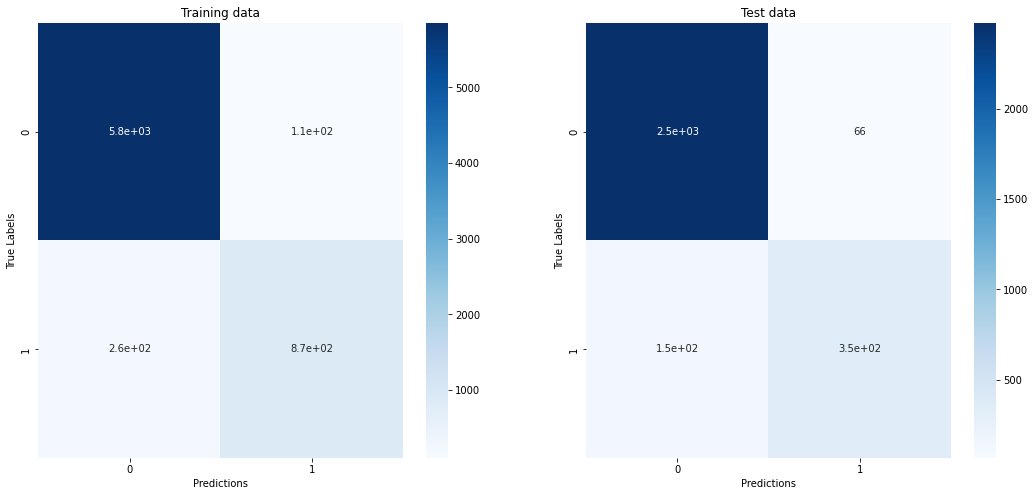

Training precision score: 0.8907
Test precision score: 0.8402
Training recall score: 0.7710
Test recall score: 0.6996
Training F1 score: 0.8265
Test F1 score: 0.7635


In [17]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pylab as plt

best_hparams = study.best_trial.params
print(best_hparams)
best_hparams_iterator = iter(study.best_trial.params)

n_layers = best_hparams[next(best_hparams_iterator)]

my_model = tf.keras.Sequential()
my_model.add(tf.keras.layers.InputLayer(input_shape = X_train.shape[1]))

for i in range(n_layers):
    num_hidden = best_hparams[next(best_hparams_iterator)]
    a_fun = best_hparams[next(best_hparams_iterator)]
    d_rate = best_hparams[next(best_hparams_iterator)]
    my_model.add(tf.keras.layers.Dense(num_hidden, activation = a_fun))
    my_model.add(tf.keras.layers.Dropout(d_rate))

my_model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

my_model.compile(loss = 'binary_crossentropy', optimizer = best_hparams['optimizer'])
my_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = best_hparams['callback_patience'])
my_model.fit(X_train_s, y_train, epochs = best_hparams['training_epochs'], validation_data = (X_test_s, y_test), callbacks = [my_callback], verbose = 0)

y_train_pred, y_test_pred = (my_model.predict(X_train_s).flatten() > 0.5)*1, (my_model.predict(X_test_s).flatten() > 0.5) * 1

# let us take a look at the confusion matrix, predictions are 1 if the predicted proability for class 1 is higher than 0.5
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

train_cm = confusion_matrix(y_train, y_train_pred)
sn.heatmap(train_cm, annot = True, cmap='Blues', ax = axs[0])

axs[0].set_xlabel('Predictions')
axs[0].set_ylabel('True Labels')
axs[0].set_title('Training data')

test_cm = confusion_matrix(y_test, y_test_pred)
sn.heatmap(test_cm, annot = True, cmap='Blues', ax = axs[1])

axs[1].set_xlabel('Predictions')
axs[1].set_ylabel('True Labels')
axs[1].set_title('Test data')

plt.show()

print(f'Training precision score: {precision_score(y_train, y_train_pred):.4f}')
print(f'Test precision score: {precision_score(y_test, y_test_pred):.4f}')
print(f'Training recall score: {recall_score(y_train, y_train_pred):.4f}')
print(f'Test recall score: {recall_score(y_test, y_test_pred):.4f}')
print(f'Training F1 score: {f1_score(y_train, y_train_pred):.4f}')
print(f'Test F1 score: {f1_score(y_test, y_test_pred):.4f}')

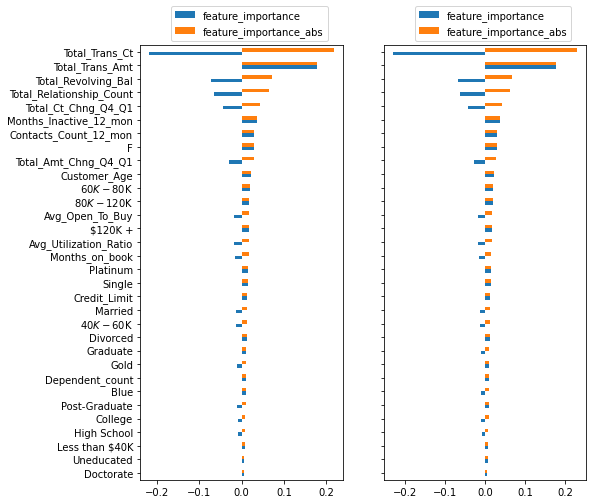

In [18]:
import numpy as np

fig, axs = plt.subplots(1, 2, figsize = (8, 8), sharey = True)

X_train_tensor = tf.convert_to_tensor(X_train_s)
X_test_tensor = tf.convert_to_tensor(X_test_s)

with tf.GradientTape() as tape:
  tape.watch(X_train_tensor)
  y_train_pred = my_model(X_train_tensor)

grads = tape.gradient(y_train_pred, X_train_tensor).numpy()

feature_importance = np.sign(np.mean(grads, axis = 0)) * np.sqrt(np.mean(grads**2, axis = 0))
feature_importance_scaled = feature_importance / np.sum(np.abs(feature_importance))
feature_importance_df = pd.DataFrame(index = X_train.columns, data = feature_importance_scaled, columns = ['feature_importance'])
feature_importance_df.loc[:, 'feature_importance_abs'] = feature_importance_df.feature_importance.abs()
feature_importance_df.sort_values(by = 'feature_importance_abs', ascending = True, inplace = True)
feature_importance_df.plot.barh(ax = axs[0])

with tf.GradientTape() as tape:
  tape.watch(X_test_tensor)
  y_test_pred = my_model(X_test_tensor)

grads = tape.gradient(y_test_pred, X_test_tensor).numpy()

feature_importance = np.sign(np.mean(grads, axis = 0)) * np.sqrt(np.mean(grads**2, axis = 0))
feature_importance_scaled = feature_importance / np.sum(np.abs(feature_importance))
feature_importance_df = pd.DataFrame(index = X_train.columns, data = feature_importance_scaled, columns = ['feature_importance'])
feature_importance_df.loc[:, 'feature_importance_abs'] = feature_importance_df.feature_importance.abs()
feature_importance_df.sort_values(by = 'feature_importance_abs', ascending = True, inplace = True)
feature_importance_df.plot.barh(ax = axs[1])


axs[0].legend(bbox_to_anchor=(0.95, 1.1))
axs[1].legend(bbox_to_anchor=(0.95, 1.1))

Next, I incorporate cross validation within the hyperparameter tuning process. This comes along with a trade-off. While hyperparameters are trained using different data sets, thus, increasing the potential for generalization, each training is done with less data which usually has a negative impact on model performance.

In [19]:
import optuna
import tensorflow as tf
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
from sklearn.model_selection import KFold

def objective(trial):
  
  # check 1 up to 3 hidden layers 
  n_layers = trial.suggest_int('n_layers', 1, 3)

  # initialize an "empty" network
  my_model = tf.keras.Sequential()
  # we define a separate input layer which specifies the shape of feature variables
  my_model.add(tf.keras.layers.InputLayer(input_shape = X_train.shape[1]))

  # for each hidden layer
  for i in range(n_layers):
    # we search for an optimal amount of hidden neurons
    num_hidden = trial.suggest_int(f'n_units_l{i}', 4, 128, log=True)
    # and among the activation functions defined below
    a_fun = trial.suggest_categorical(f'a_fun_l{i}', ['tanh', 'sigmoid', 'relu'])  
    # add this hidden layer
    my_model.add(tf.keras.layers.Dense(num_hidden, activation = a_fun))
    # add dropout against overfitting
    dropout_rate = trial.suggest_float(f'drate_l{i}', 0.0, 1.0)
    my_model.add(tf.keras.layers.Dropout(dropout_rate))


  # in the end add an output to predict the housing value
  my_model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

  # and two optimizers
  optim = trial.suggest_categorical(f'optimizer', ['Adam', 'RMSprop'])

  # compile the model
  my_model.compile(loss = 'binary_crossentropy', optimizer = optim)

  # this step is important in my opinion, for each fold the network is supposed to train from scratch
  # this is why we save the initial parameters of the network and set them as a start once the network
  # is newly estimated for a new fold of the data
  init_weights = my_model.get_weights()

  # different callback parameters are available, we try the number of steps to wait for improvement of validation data
  # once the loss value for validation data does not improve for the number of patience steps the network optimization stops
  callback_patience = trial.suggest_int(f'callback_patience', 1, 5)
  my_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = callback_patience)

  # if the loss for validation data always improves, the model is trained until the maximum number of epochs is reached
  n_epochs = trial.suggest_int(f'training_epochs', 10, 100)
  
  f1_val = []

  # let us also optimize the number of folds
  kfold_splits = trial.suggest_int(f'kfolds', 2, 5)
  kfold = KFold(n_splits = kfold_splits, shuffle = True)

  for i, (train_index, val_index) in enumerate(kfold.split(X_train_s)):
    X_train_fold, y_train_fold = X_train_s[train_index], y_train[train_index]
    X_val_fold, y_val_fold = X_train_s[val_index], y_train[val_index]

    my_model.set_weights(init_weights)
    my_model.fit(X_train_fold, y_train_fold, epochs = n_epochs, validation_data = (X_val_fold, y_val_fold), callbacks = [my_callback], verbose = 0)

  y_val_pred = (my_model.predict(X_val_fold).flatten() > 0.5)*1
  f1_val.append(f1_score(y_val_fold, y_val_pred))
  
  return np.mean(f1_val)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2022-11-28 09:00:21,241] A new study created in memory with name: no-name-7f8a7e41-a905-4766-a5f4-8451ff523304


74/74 [==============================] - 0s 2ms/step


[I 2022-11-28 09:02:05,084] Trial 0 finished with value: 0.0 and parameters: {'n_layers': 3, 'n_units_l0': 8, 'a_fun_l0': 'relu', 'drate_l0': 0.8786163456748312, 'n_units_l1': 27, 'a_fun_l1': 'tanh', 'drate_l1': 0.8638682091989068, 'n_units_l2': 36, 'a_fun_l2': 'relu', 'drate_l2': 0.1985856883763345, 'optimizer': 'RMSprop', 'callback_patience': 5, 'training_epochs': 78, 'kfolds': 3}. Best is trial 0 with value: 0.0.


111/111 [==============================] - 0s 1ms/step


[I 2022-11-28 09:02:24,520] Trial 1 finished with value: 0.6526315789473685 and parameters: {'n_layers': 1, 'n_units_l0': 37, 'a_fun_l0': 'tanh', 'drate_l0': 0.4684877695541002, 'optimizer': 'RMSprop', 'callback_patience': 4, 'training_epochs': 31, 'kfolds': 2}. Best is trial 1 with value: 0.6526315789473685.


74/74 [==============================] - 0s 1ms/step


[I 2022-11-28 09:02:57,300] Trial 2 finished with value: 0.7453769559032716 and parameters: {'n_layers': 1, 'n_units_l0': 91, 'a_fun_l0': 'relu', 'drate_l0': 0.2054299459794522, 'optimizer': 'Adam', 'callback_patience': 4, 'training_epochs': 33, 'kfolds': 3}. Best is trial 2 with value: 0.7453769559032716.


74/74 [==============================] - 0s 1ms/step


[I 2022-11-28 09:04:24,809] Trial 3 finished with value: 0.7536656891495602 and parameters: {'n_layers': 1, 'n_units_l0': 13, 'a_fun_l0': 'relu', 'drate_l0': 0.18692662774762936, 'optimizer': 'Adam', 'callback_patience': 5, 'training_epochs': 82, 'kfolds': 3}. Best is trial 3 with value: 0.7536656891495602.


45/45 [==============================] - 0s 2ms/step


[I 2022-11-28 09:06:32,809] Trial 4 finished with value: 0.7487437185929648 and parameters: {'n_layers': 2, 'n_units_l0': 7, 'a_fun_l0': 'tanh', 'drate_l0': 0.03123052067307308, 'n_units_l1': 10, 'a_fun_l1': 'tanh', 'drate_l1': 0.10243447550950868, 'optimizer': 'Adam', 'callback_patience': 3, 'training_epochs': 76, 'kfolds': 5}. Best is trial 3 with value: 0.7536656891495602.


56/56 [==============================] - 0s 1ms/step


[I 2022-11-28 09:07:33,193] Trial 5 finished with value: 0.689795918367347 and parameters: {'n_layers': 2, 'n_units_l0': 10, 'a_fun_l0': 'relu', 'drate_l0': 0.3020103205127421, 'n_units_l1': 54, 'a_fun_l1': 'sigmoid', 'drate_l1': 0.4107252475950258, 'optimizer': 'Adam', 'callback_patience': 3, 'training_epochs': 30, 'kfolds': 4}. Best is trial 3 with value: 0.7536656891495602.


45/45 [==============================] - 0s 2ms/step


[I 2022-11-28 09:08:13,428] Trial 6 finished with value: 0.6735218508997429 and parameters: {'n_layers': 2, 'n_units_l0': 13, 'a_fun_l0': 'tanh', 'drate_l0': 0.7322815253730998, 'n_units_l1': 50, 'a_fun_l1': 'relu', 'drate_l1': 0.40695293290580525, 'optimizer': 'RMSprop', 'callback_patience': 1, 'training_epochs': 38, 'kfolds': 5}. Best is trial 3 with value: 0.7536656891495602.


74/74 [==============================] - 0s 2ms/step


[I 2022-11-28 09:08:26,706] Trial 7 finished with value: 0.6602209944751382 and parameters: {'n_layers': 2, 'n_units_l0': 116, 'a_fun_l0': 'tanh', 'drate_l0': 0.22020305104043958, 'n_units_l1': 110, 'a_fun_l1': 'sigmoid', 'drate_l1': 0.35335515573660403, 'optimizer': 'RMSprop', 'callback_patience': 2, 'training_epochs': 18, 'kfolds': 3}. Best is trial 3 with value: 0.7536656891495602.


74/74 [==============================] - 0s 2ms/step


[I 2022-11-28 09:09:14,758] Trial 8 finished with value: 0.6246246246246246 and parameters: {'n_layers': 1, 'n_units_l0': 12, 'a_fun_l0': 'tanh', 'drate_l0': 0.7693146046252346, 'optimizer': 'RMSprop', 'callback_patience': 5, 'training_epochs': 83, 'kfolds': 3}. Best is trial 3 with value: 0.7536656891495602.


74/74 [==============================] - 0s 2ms/step


[I 2022-11-28 09:09:38,639] Trial 9 finished with value: 0.6729857819905214 and parameters: {'n_layers': 2, 'n_units_l0': 79, 'a_fun_l0': 'tanh', 'drate_l0': 0.21999069940952876, 'n_units_l1': 4, 'a_fun_l1': 'relu', 'drate_l1': 0.2040901716839819, 'optimizer': 'Adam', 'callback_patience': 3, 'training_epochs': 15, 'kfolds': 3}. Best is trial 3 with value: 0.7536656891495602.


111/111 [==============================] - 0s 1ms/step


[I 2022-11-28 09:10:10,525] Trial 10 finished with value: 0.0 and parameters: {'n_layers': 3, 'n_units_l0': 4, 'a_fun_l0': 'sigmoid', 'drate_l0': 0.5278877964002353, 'n_units_l1': 4, 'a_fun_l1': 'sigmoid', 'drate_l1': 0.9772610621677047, 'n_units_l2': 4, 'a_fun_l2': 'sigmoid', 'drate_l2': 0.9586017528191453, 'optimizer': 'Adam', 'callback_patience': 5, 'training_epochs': 97, 'kfolds': 2}. Best is trial 3 with value: 0.7536656891495602.


45/45 [==============================] - 0s 1ms/step


[I 2022-11-28 09:12:57,344] Trial 11 finished with value: 0.6878306878306878 and parameters: {'n_layers': 1, 'n_units_l0': 4, 'a_fun_l0': 'sigmoid', 'drate_l0': 0.06001086172022341, 'optimizer': 'Adam', 'callback_patience': 2, 'training_epochs': 63, 'kfolds': 5}. Best is trial 3 with value: 0.7536656891495602.


56/56 [==============================] - 0s 2ms/step


[I 2022-11-28 09:13:47,297] Trial 12 finished with value: 0.7806563039723661 and parameters: {'n_layers': 3, 'n_units_l0': 27, 'a_fun_l0': 'relu', 'drate_l0': 0.04035885707207956, 'n_units_l1': 11, 'a_fun_l1': 'tanh', 'drate_l1': 0.011235346519304426, 'n_units_l2': 115, 'a_fun_l2': 'tanh', 'drate_l2': 0.7772997905135595, 'optimizer': 'Adam', 'callback_patience': 4, 'training_epochs': 63, 'kfolds': 4}. Best is trial 12 with value: 0.7806563039723661.


56/56 [==============================] - 0s 1ms/step


[I 2022-11-28 09:15:07,528] Trial 13 finished with value: 0.7357723577235772 and parameters: {'n_layers': 3, 'n_units_l0': 27, 'a_fun_l0': 'relu', 'drate_l0': 0.3855237281230868, 'n_units_l1': 11, 'a_fun_l1': 'tanh', 'drate_l1': 0.05490636470067839, 'n_units_l2': 123, 'a_fun_l2': 'tanh', 'drate_l2': 0.7998719673766711, 'optimizer': 'Adam', 'callback_patience': 4, 'training_epochs': 55, 'kfolds': 4}. Best is trial 12 with value: 0.7806563039723661.


56/56 [==============================] - 0s 2ms/step


[I 2022-11-28 09:16:16,616] Trial 14 finished with value: 0.730050933786078 and parameters: {'n_layers': 3, 'n_units_l0': 21, 'a_fun_l0': 'relu', 'drate_l0': 0.01757136242003038, 'n_units_l1': 12, 'a_fun_l1': 'tanh', 'drate_l1': 0.6847128449046489, 'n_units_l2': 118, 'a_fun_l2': 'tanh', 'drate_l2': 0.5238178293123736, 'optimizer': 'Adam', 'callback_patience': 4, 'training_epochs': 57, 'kfolds': 4}. Best is trial 12 with value: 0.7806563039723661.


56/56 [==============================] - 0s 1ms/step


[I 2022-11-28 09:17:46,898] Trial 15 finished with value: 0.7711711711711712 and parameters: {'n_layers': 1, 'n_units_l0': 43, 'a_fun_l0': 'relu', 'drate_l0': 0.1309441031930476, 'optimizer': 'Adam', 'callback_patience': 5, 'training_epochs': 100, 'kfolds': 4}. Best is trial 12 with value: 0.7806563039723661.


56/56 [==============================] - 0s 2ms/step


[I 2022-11-28 09:19:31,566] Trial 16 finished with value: 0.7360861759425494 and parameters: {'n_layers': 3, 'n_units_l0': 46, 'a_fun_l0': 'relu', 'drate_l0': 0.621260903016693, 'n_units_l1': 7, 'a_fun_l1': 'tanh', 'drate_l1': 0.6300831338845451, 'n_units_l2': 22, 'a_fun_l2': 'tanh', 'drate_l2': 0.6063225674558838, 'optimizer': 'Adam', 'callback_patience': 4, 'training_epochs': 100, 'kfolds': 4}. Best is trial 12 with value: 0.7806563039723661.


56/56 [==============================] - 0s 1ms/step


[I 2022-11-28 09:20:44,325] Trial 17 finished with value: 0.7704280155642023 and parameters: {'n_layers': 2, 'n_units_l0': 56, 'a_fun_l0': 'relu', 'drate_l0': 0.0997516147607888, 'n_units_l1': 22, 'a_fun_l1': 'relu', 'drate_l1': 0.23339861402612133, 'optimizer': 'Adam', 'callback_patience': 5, 'training_epochs': 47, 'kfolds': 4}. Best is trial 12 with value: 0.7806563039723661.


45/45 [==============================] - 0s 2ms/step


[I 2022-11-28 09:23:19,128] Trial 18 finished with value: 0.7398568019093079 and parameters: {'n_layers': 2, 'n_units_l0': 23, 'a_fun_l0': 'sigmoid', 'drate_l0': 0.34922886977606904, 'n_units_l1': 36, 'a_fun_l1': 'tanh', 'drate_l1': 0.6052659944977374, 'optimizer': 'Adam', 'callback_patience': 4, 'training_epochs': 68, 'kfolds': 5}. Best is trial 12 with value: 0.7806563039723661.


56/56 [==============================] - 0s 1ms/step


[I 2022-11-28 09:24:04,932] Trial 19 finished with value: 0.7534516765285997 and parameters: {'n_layers': 1, 'n_units_l0': 32, 'a_fun_l0': 'relu', 'drate_l0': 0.14239024262540378, 'optimizer': 'Adam', 'callback_patience': 2, 'training_epochs': 91, 'kfolds': 4}. Best is trial 12 with value: 0.7806563039723661.


{'n_layers': 3, 'n_units_l0': 27, 'a_fun_l0': 'relu', 'drate_l0': 0.04035885707207956, 'n_units_l1': 11, 'a_fun_l1': 'tanh', 'drate_l1': 0.011235346519304426, 'n_units_l2': 115, 'a_fun_l2': 'tanh', 'drate_l2': 0.7772997905135595, 'optimizer': 'Adam', 'callback_patience': 4, 'training_epochs': 63, 'kfolds': 4}
95/95 [==============================] - 0s 2ms/step


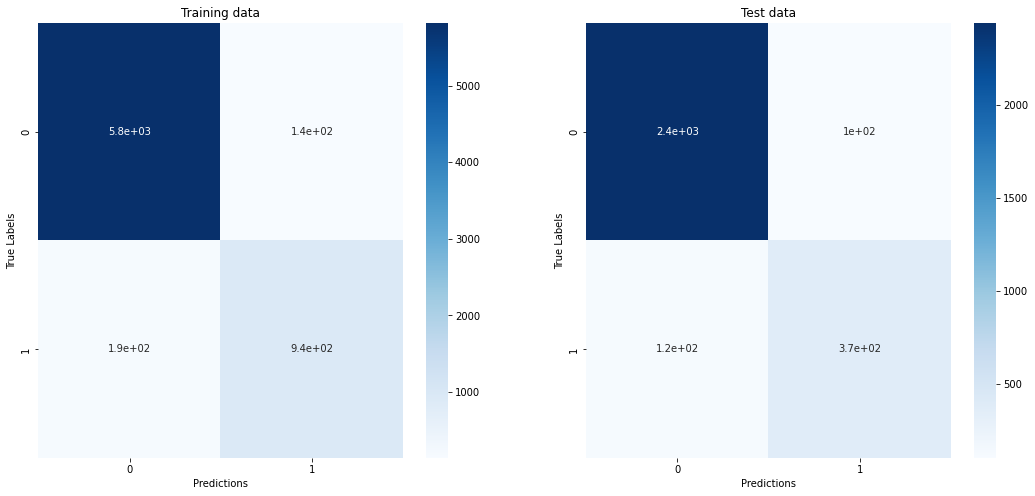

Training precision score: 0.8726
Test precision score: 0.7827
Training recall score: 0.8355
Test recall score: 0.7480
Training F1 score: 0.8537
Test F1 score: 0.7649


In [20]:

from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pylab as plt

best_hparams = study.best_trial.params
print(best_hparams)
best_hparams_iterator = iter(study.best_trial.params)

n_layers = best_hparams[next(best_hparams_iterator)]

my_model = tf.keras.Sequential()
my_model.add(tf.keras.layers.InputLayer(input_shape = X_train.shape[1]))

for i in range(n_layers):
    num_hidden = best_hparams[next(best_hparams_iterator)]
    a_fun = best_hparams[next(best_hparams_iterator)]
    d_rate = best_hparams[next(best_hparams_iterator)]
    my_model.add(tf.keras.layers.Dense(num_hidden, activation = a_fun))
    my_model.add(tf.keras.layers.Dropout(d_rate))

my_model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

my_model.compile(loss = 'binary_crossentropy', optimizer = best_hparams['optimizer'])
my_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = best_hparams['callback_patience'])
my_model.fit(X_train_s, y_train, epochs = best_hparams['training_epochs'], validation_data = (X_test_s, y_test), callbacks = [my_callback], verbose = 0)

y_train_pred, y_test_pred = (my_model.predict(X_train_s).flatten() > 0.5)*1, (my_model.predict(X_test_s).flatten() > 0.5) * 1

# let us take a look at the confusion matrix, predictions are 1 if the predicted proability for class 1 is higher than 0.5
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

train_cm = confusion_matrix(y_train, y_train_pred)
sn.heatmap(train_cm, annot = True, cmap='Blues', ax = axs[0])

axs[0].set_xlabel('Predictions')
axs[0].set_ylabel('True Labels')
axs[0].set_title('Training data')

test_cm = confusion_matrix(y_test, y_test_pred)
sn.heatmap(test_cm, annot = True, cmap='Blues', ax = axs[1])

axs[1].set_xlabel('Predictions')
axs[1].set_ylabel('True Labels')
axs[1].set_title('Test data')

plt.show()

print(f'Training precision score: {precision_score(y_train, y_train_pred):.4f}')
print(f'Test precision score: {precision_score(y_test, y_test_pred):.4f}')
print(f'Training recall score: {recall_score(y_train, y_train_pred):.4f}')
print(f'Test recall score: {recall_score(y_test, y_test_pred):.4f}')
print(f'Training F1 score: {f1_score(y_train, y_train_pred):.4f}')
print(f'Test F1 score: {f1_score(y_test, y_test_pred):.4f}')

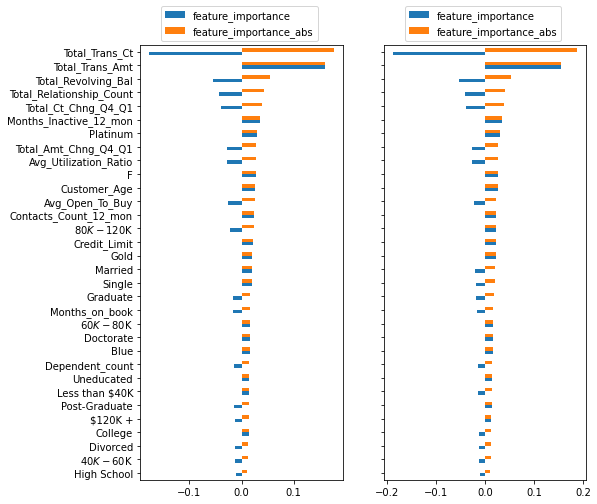

In [21]:
import numpy as np

fig, axs = plt.subplots(1, 2, figsize = (8, 8), sharey = True)

X_train_tensor = tf.convert_to_tensor(X_train_s)
X_test_tensor = tf.convert_to_tensor(X_test_s)

with tf.GradientTape() as tape:
  tape.watch(X_train_tensor)
  y_train_pred = my_model(X_train_tensor)

grads = tape.gradient(y_train_pred, X_train_tensor).numpy()

feature_importance = np.sign(np.mean(grads, axis = 0)) * np.sqrt(np.mean(grads**2, axis = 0))
feature_importance_scaled = feature_importance / np.sum(np.abs(feature_importance))
feature_importance_df = pd.DataFrame(index = X_train.columns, data = feature_importance_scaled, columns = ['feature_importance'])
feature_importance_df.loc[:, 'feature_importance_abs'] = feature_importance_df.feature_importance.abs()
feature_importance_df.sort_values(by = 'feature_importance_abs', ascending = True, inplace = True)
feature_importance_df.plot.barh(ax = axs[0])

with tf.GradientTape() as tape:
  tape.watch(X_test_tensor)
  y_test_pred = my_model(X_test_tensor)

grads = tape.gradient(y_test_pred, X_test_tensor).numpy()

feature_importance = np.sign(np.mean(grads, axis = 0)) * np.sqrt(np.mean(grads**2, axis = 0))
feature_importance_scaled = feature_importance / np.sum(np.abs(feature_importance))
feature_importance_df = pd.DataFrame(index = X_train.columns, data = feature_importance_scaled, columns = ['feature_importance'])
feature_importance_df.loc[:, 'feature_importance_abs'] = feature_importance_df.feature_importance.abs()
feature_importance_df.sort_values(by = 'feature_importance_abs', ascending = True, inplace = True)
feature_importance_df.plot.barh(ax = axs[1])


axs[0].legend(bbox_to_anchor=(0.9, 1.1))
axs[1].legend(bbox_to_anchor=(0.9, 1.1))

Despite the performance boost by the neural network, we still observe imbalances between false positives and false negatives. This may be due to the overweight of negatives in the data which is why the model is less "focused" on the positive category, hereby, generating lower positive predictions. We try to improve this behavior by creating synthetic data for the attrited customer category and retrain all models as before.

In [22]:
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler

# we use SMOTENC which is capable for mixed features (numerical and categorical)
# synthetic observations for categorical features are chosen by majority categories per feature
# see some information here: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC
# we need to tell SMOTENC which features are categorical

smt = SMOTENC(categorical_features = list(range(14, 32)), sampling_strategy = 0.5)
X_train_sm, y_train_sm = smt.fit_resample(X_train.values, y_train)

# we use standard scaling, alternatives are, e.g., min-max-scaling or quantile-transformers
scaler = StandardScaler()
scaler.fit(X_train_sm)

# neural networks only need standardized feature data
X_train_sm_s, X_test_s = scaler.transform(X_train_sm), scaler.transform(X_test.values)

When we take a look at the logistic regression results below, we mainly observe the following things. The imbalance between false positive and false negatives decreases and model performance slightly improves. However, at the same time divergence between training and test results increases. Moreover feature importance changes. Especially, the latter is critical in my point of view, because due to non-existing synthetic data, inferences regarding specific features is difference and may misguide decision-makers. 

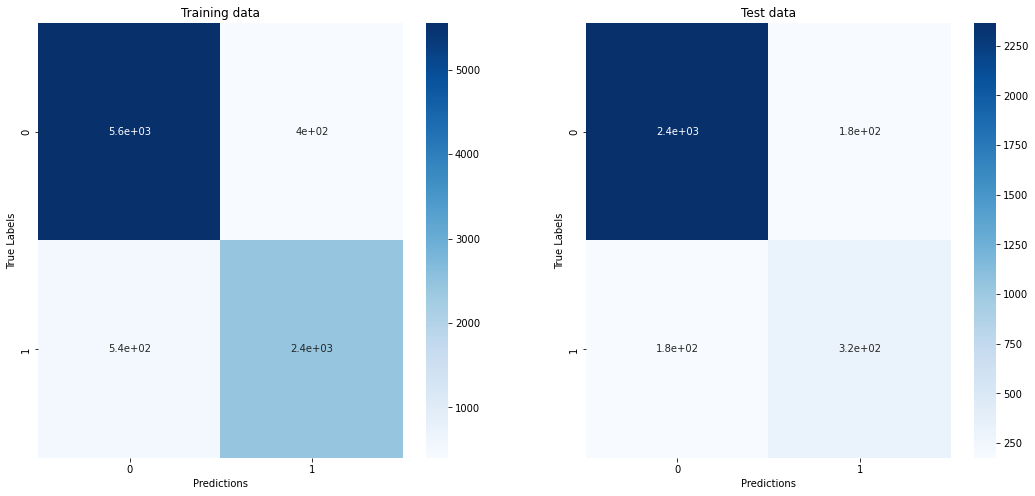

Training precision score: 0.8578
Test precision score: 0.6420
Training recall score: 0.8187
Test recall score: 0.6472
Training F1 score: 0.8378
Test F1 score: 0.6446


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pylab as plt

log_reg = LogisticRegression()
log_reg.fit(X_train_sm_s, y_train_sm)

y_train_pred = log_reg.predict(X_train_sm_s)
y_test_pred = log_reg.predict(X_test_s) 

# let us take a look at the confusion matrix, predictions are 1 if the predicted proability for class 1 is higher than 0.5
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

train_cm = confusion_matrix(y_train_sm, y_train_pred)
sn.heatmap(train_cm, annot = True, cmap='Blues', ax = axs[0])

axs[0].set_xlabel('Predictions')
axs[0].set_ylabel('True Labels')
axs[0].set_title('Training data')

test_cm = confusion_matrix(y_test, y_test_pred)
sn.heatmap(test_cm, annot = True, cmap='Blues', ax = axs[1])

axs[1].set_xlabel('Predictions')
axs[1].set_ylabel('True Labels')
axs[1].set_title('Test data')

plt.show()

print(f'Training precision score: {precision_score(y_train_sm, y_train_pred):.4f}')
print(f'Test precision score: {precision_score(y_test, y_test_pred):.4f}')
print(f'Training recall score: {recall_score(y_train_sm, y_train_pred):.4f}')
print(f'Test recall score: {recall_score(y_test, y_test_pred):.4f}')
print(f'Training F1 score: {f1_score(y_train_sm, y_train_pred):.4f}')
print(f'Test F1 score: {f1_score(y_test, y_test_pred):.4f}')

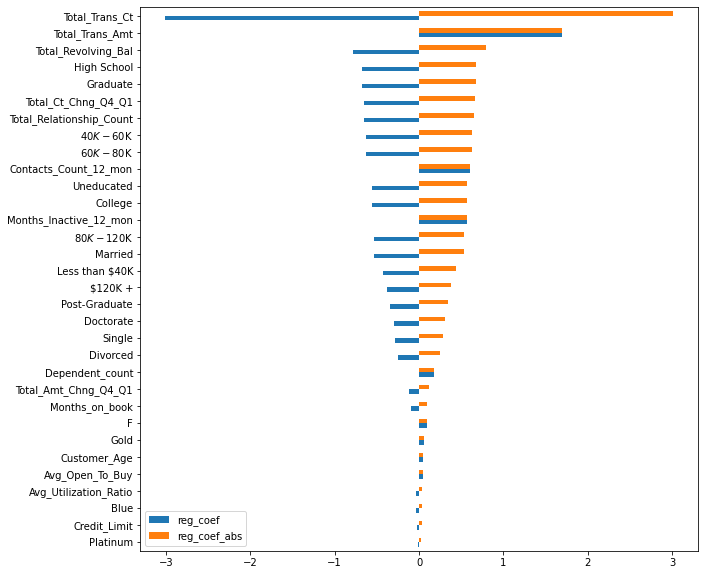

In [24]:
log_reg_coef = pd.DataFrame(data = log_reg.coef_.flatten(), index = X_train.columns, columns = ['reg_coef'])
log_reg_coef.loc[:, 'reg_coef_abs'] = log_reg_coef.reg_coef.abs()
log_reg_coef.sort_values(by = 'reg_coef_abs', ascending = True, inplace = True)
log_reg_coef.plot.barh(figsize = (10, 10))

Epoch 1/50
280/280 [==============================] - 2s 4ms/step - loss: 0.4547 - val_loss: 0.3095
Epoch 2/50
280/280 [==============================] - 1s 3ms/step - loss: 0.3215 - val_loss: 0.2932
Epoch 3/50
280/280 [==============================] - 1s 3ms/step - loss: 0.2973 - val_loss: 0.2892
Epoch 4/50
280/280 [==============================] - 1s 3ms/step - loss: 0.2919 - val_loss: 0.2878
Epoch 5/50
280/280 [==============================] - 1s 3ms/step - loss: 0.2847 - val_loss: 0.2851
Epoch 6/50
280/280 [==============================] - 1s 3ms/step - loss: 0.2789 - val_loss: 0.2796
Epoch 7/50
280/280 [==============================] - 1s 3ms/step - loss: 0.2758 - val_loss: 0.2806
Epoch 8/50
280/280 [==============================] - 1s 3ms/step - loss: 0.2698 - val_loss: 0.2765
Epoch 9/50
280/280 [==============================] - 1s 3ms/step - loss: 0.2732 - val_loss: 0.2773
Epoch 10/50
280/280 [==============================] - 1s 3ms/step - loss: 0.2679 - val_loss: 0.2761

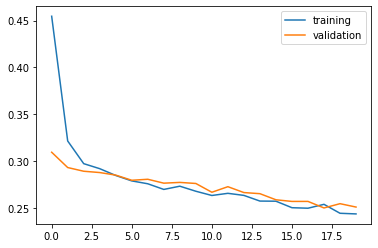

In [25]:
import tensorflow as tf
import matplotlib.pylab as plt

# define a neural network using the keras sequential api
my_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (X_train_s.shape[1])),
    tf.keras.layers.Dense(20, activation = 'tanh', name = 'hidden_layer'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(10, activation = 'tanh', name = 'hidden_layer2'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# alternative choices for the loss would be, e.g., the mean absolute error or the huber loss
my_model.compile(loss = 'binary_crossentropy', optimizer = 'Adam')
my_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2)
history = my_model.fit(X_train_sm_s, y_train_sm, epochs = 50, validation_data = (X_test_s, y_test), callbacks = [my_callback])

# we can visualize the evaluation of the loss during training
plt.plot(history.history['loss'], label = 'training')
plt.plot(history.history['val_loss'], label = 'validation')
plt.legend()
plt.show()

95/95 [==============================] - 0s 1ms/step


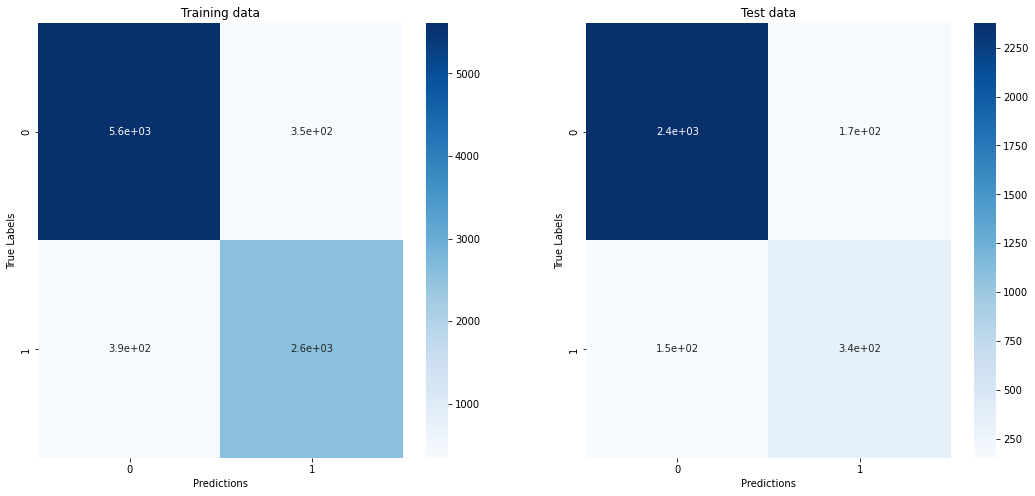

Training precision score: 0.8816
Test precision score: 0.6745
Training recall score: 0.8677
Test recall score: 0.6935
Training F1 score: 0.8746
Test F1 score: 0.6839


In [26]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pylab as plt

y_train_pred, y_test_pred = (my_model.predict(X_train_sm_s).flatten() > 0.5)*1, (my_model.predict(X_test_s).flatten() > 0.5) * 1

# let us take a look at the confusion matrix, predictions are 1 if the predicted proability for class 1 is higher than 0.5
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

train_cm = confusion_matrix(y_train_sm, y_train_pred)
sn.heatmap(train_cm, annot = True, cmap='Blues', ax = axs[0])

axs[0].set_xlabel('Predictions')
axs[0].set_ylabel('True Labels')
axs[0].set_title('Training data')

test_cm = confusion_matrix(y_test, y_test_pred)
sn.heatmap(test_cm, annot = True, cmap='Blues', ax = axs[1])

axs[1].set_xlabel('Predictions')
axs[1].set_ylabel('True Labels')
axs[1].set_title('Test data')

plt.show()

print(f'Training precision score: {precision_score(y_train_sm, y_train_pred):.4f}')
print(f'Test precision score: {precision_score(y_test, y_test_pred):.4f}')
print(f'Training recall score: {recall_score(y_train_sm, y_train_pred):.4f}')
print(f'Test recall score: {recall_score(y_test, y_test_pred):.4f}')
print(f'Training F1 score: {f1_score(y_train_sm, y_train_pred):.4f}')
print(f'Test F1 score: {f1_score(y_test, y_test_pred):.4f}')

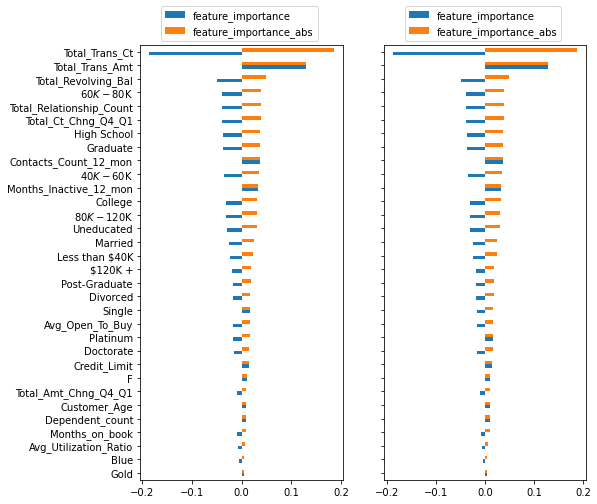

In [27]:
import numpy as np

fig, axs = plt.subplots(1, 2, figsize = (8, 8), sharey = True)

X_train_tensor = tf.convert_to_tensor(X_train_sm_s)
X_test_tensor = tf.convert_to_tensor(X_test_s)

with tf.GradientTape() as tape:
  tape.watch(X_train_tensor)
  y_train_pred = my_model(X_train_tensor)

grads = tape.gradient(y_train_pred, X_train_tensor).numpy()

feature_importance = np.sign(np.mean(grads, axis = 0)) * np.sqrt(np.mean(grads**2, axis = 0))
feature_importance_scaled = feature_importance / np.sum(np.abs(feature_importance))
feature_importance_df = pd.DataFrame(index = X_train.columns, data = feature_importance_scaled, columns = ['feature_importance'])
feature_importance_df.loc[:, 'feature_importance_abs'] = feature_importance_df.feature_importance.abs()
feature_importance_df.sort_values(by = 'feature_importance_abs', ascending = True, inplace = True)
feature_importance_df.plot.barh(ax = axs[0])

with tf.GradientTape() as tape:
  tape.watch(X_test_tensor)
  y_test_pred = my_model(X_test_tensor)

grads = tape.gradient(y_test_pred, X_test_tensor).numpy()

feature_importance = np.sign(np.mean(grads, axis = 0)) * np.sqrt(np.mean(grads**2, axis = 0))
feature_importance_scaled = feature_importance / np.sum(np.abs(feature_importance))
feature_importance_df = pd.DataFrame(index = X_train.columns, data = feature_importance_scaled, columns = ['feature_importance'])
feature_importance_df.loc[:, 'feature_importance_abs'] = feature_importance_df.feature_importance.abs()
feature_importance_df.sort_values(by = 'feature_importance_abs', ascending = True, inplace = True)
feature_importance_df.plot.barh(ax = axs[1])


axs[0].legend(bbox_to_anchor=(0.9, 1.1))
axs[1].legend(bbox_to_anchor=(0.9, 1.1))

In [28]:
import optuna
import tensorflow as tf
from sklearn.metrics import f1_score, precision_score, recall_score


# define an objective function whose output is optimized with respect to trial instances
def objective(trial):
  
  # check 1 up to 3 hidden layers 
  n_layers = trial.suggest_int('n_layers', 1, 3)

  # initialize an "empty" network
  my_model = tf.keras.Sequential()
  # we define a separate input layer which specifies the shape of feature variables
  my_model.add(tf.keras.layers.InputLayer(input_shape = X_train.shape[1]))

  # for each hidden layer
  for i in range(n_layers):
    # we search for an optimal amount of hidden neurons
    num_hidden = trial.suggest_int(f'n_units_l{i}', 4, 128, log=True)
    # and among the activation functions defined below
    a_fun = trial.suggest_categorical(f'a_fun_l{i}', ['tanh', 'sigmoid', 'relu'])  
    # add this hidden layer
    my_model.add(tf.keras.layers.Dense(num_hidden, activation = a_fun))
    # add dropout against overfitting
    dropout_rate = trial.suggest_float(f'drate_l{i}', 0.1, 0.5)
    my_model.add(tf.keras.layers.Dropout(dropout_rate))

  # in the end add an output 
  my_model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

  # two optimizers
  optim = trial.suggest_categorical(f'optimizer', ['Adam', 'RMSprop'])

  # compile the model
  my_model.compile(loss = 'binary_crossentropy', optimizer = optim)
  
  # different callback parameters are available, we try the number of steps to wait for improvement of validation data
  # once the loss value for validation data does not improve for the number of patience steps the network optimization stops
  callback_patience = trial.suggest_int(f'callback_patience', 1, 5)
  my_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = callback_patience)

  # if the loss for validation data always improves, the model is trained until the maximum number of epochs is reached
  n_epochs = trial.suggest_int(f'training_epochs', 10, 100)
  my_model.fit(X_train_sm_s, y_train_sm, epochs = n_epochs, validation_data = (X_test_s, y_test), callbacks = [my_callback], verbose = 0)

  # we aim to maximize validation/test data's R^2 which we output for the objective 
  y_test_pred = (my_model.predict(X_test_s).flatten() > 0.5) * 1
  f1_test = f1_score(y_test, y_test_pred)

  return f1_test

# create an optim study instance
study = optuna.create_study(direction='maximize')
# optimize hyperparameters for n_trials 
study.optimize(objective, n_trials=20)

[I 2022-11-28 09:24:55,913] A new study created in memory with name: no-name-4debee4c-dc4d-45a6-aa91-dfab626515ca


95/95 [==============================] - 0s 2ms/step


[I 2022-11-28 09:25:06,976] Trial 0 finished with value: 0.6499999999999999 and parameters: {'n_layers': 3, 'n_units_l0': 65, 'a_fun_l0': 'sigmoid', 'drate_l0': 0.10170546248433912, 'n_units_l1': 91, 'a_fun_l1': 'sigmoid', 'drate_l1': 0.4804400747012648, 'n_units_l2': 24, 'a_fun_l2': 'relu', 'drate_l2': 0.45353374031734395, 'optimizer': 'Adam', 'callback_patience': 5, 'training_epochs': 28}. Best is trial 0 with value: 0.6499999999999999.


95/95 [==============================] - 0s 1ms/step


[I 2022-11-28 09:25:33,528] Trial 1 finished with value: 0.6869300911854103 and parameters: {'n_layers': 1, 'n_units_l0': 5, 'a_fun_l0': 'tanh', 'drate_l0': 0.1972126433075487, 'optimizer': 'Adam', 'callback_patience': 4, 'training_epochs': 47}. Best is trial 1 with value: 0.6869300911854103.


95/95 [==============================] - 0s 1ms/step


[I 2022-11-28 09:25:55,684] Trial 2 finished with value: 0.736 and parameters: {'n_layers': 2, 'n_units_l0': 10, 'a_fun_l0': 'tanh', 'drate_l0': 0.14783325554896332, 'n_units_l1': 22, 'a_fun_l1': 'tanh', 'drate_l1': 0.20192786097019397, 'optimizer': 'Adam', 'callback_patience': 2, 'training_epochs': 74}. Best is trial 2 with value: 0.736.


95/95 [==============================] - 0s 1ms/step


[I 2022-11-28 09:26:04,891] Trial 3 finished with value: 0.7103935418768921 and parameters: {'n_layers': 1, 'n_units_l0': 78, 'a_fun_l0': 'tanh', 'drate_l0': 0.13812121005378628, 'optimizer': 'RMSprop', 'callback_patience': 1, 'training_epochs': 41}. Best is trial 2 with value: 0.736.


95/95 [==============================] - 0s 1ms/step


[I 2022-11-28 09:26:26,320] Trial 4 finished with value: 0.7362086258776329 and parameters: {'n_layers': 1, 'n_units_l0': 19, 'a_fun_l0': 'relu', 'drate_l0': 0.11960607419048097, 'optimizer': 'Adam', 'callback_patience': 4, 'training_epochs': 82}. Best is trial 4 with value: 0.7362086258776329.


95/95 [==============================] - 0s 1ms/step


[I 2022-11-28 09:26:48,229] Trial 5 finished with value: 0.6987951807228915 and parameters: {'n_layers': 3, 'n_units_l0': 13, 'a_fun_l0': 'relu', 'drate_l0': 0.47180907553385043, 'n_units_l1': 5, 'a_fun_l1': 'tanh', 'drate_l1': 0.3067543329372993, 'n_units_l2': 75, 'a_fun_l2': 'sigmoid', 'drate_l2': 0.33006105697043675, 'optimizer': 'RMSprop', 'callback_patience': 4, 'training_epochs': 34}. Best is trial 4 with value: 0.7362086258776329.


95/95 [==============================] - 0s 1ms/step


[I 2022-11-28 09:27:04,782] Trial 6 finished with value: 0.6755373592630501 and parameters: {'n_layers': 2, 'n_units_l0': 6, 'a_fun_l0': 'relu', 'drate_l0': 0.3360210051933107, 'n_units_l1': 8, 'a_fun_l1': 'tanh', 'drate_l1': 0.19979884624739658, 'optimizer': 'RMSprop', 'callback_patience': 2, 'training_epochs': 90}. Best is trial 4 with value: 0.7362086258776329.


95/95 [==============================] - 0s 1ms/step


[I 2022-11-28 09:27:26,355] Trial 7 finished with value: 0.7194525904203324 and parameters: {'n_layers': 2, 'n_units_l0': 48, 'a_fun_l0': 'tanh', 'drate_l0': 0.17589481581903932, 'n_units_l1': 4, 'a_fun_l1': 'relu', 'drate_l1': 0.16748864003302455, 'optimizer': 'RMSprop', 'callback_patience': 4, 'training_epochs': 62}. Best is trial 4 with value: 0.7362086258776329.


95/95 [==============================] - 0s 2ms/step


[I 2022-11-28 09:28:01,060] Trial 8 finished with value: 0.733264675592173 and parameters: {'n_layers': 3, 'n_units_l0': 44, 'a_fun_l0': 'tanh', 'drate_l0': 0.31635263776513944, 'n_units_l1': 4, 'a_fun_l1': 'tanh', 'drate_l1': 0.2787948052041448, 'n_units_l2': 83, 'a_fun_l2': 'tanh', 'drate_l2': 0.2232562546484781, 'optimizer': 'RMSprop', 'callback_patience': 5, 'training_epochs': 96}. Best is trial 4 with value: 0.7362086258776329.


95/95 [==============================] - 0s 1ms/step


[I 2022-11-28 09:28:10,682] Trial 9 finished with value: 0.6538071065989848 and parameters: {'n_layers': 1, 'n_units_l0': 30, 'a_fun_l0': 'tanh', 'drate_l0': 0.2921959762324411, 'optimizer': 'Adam', 'callback_patience': 5, 'training_epochs': 15}. Best is trial 4 with value: 0.7362086258776329.


95/95 [==============================] - 0s 2ms/step


[I 2022-11-28 09:28:21,783] Trial 10 finished with value: 0.7616161616161616 and parameters: {'n_layers': 1, 'n_units_l0': 127, 'a_fun_l0': 'relu', 'drate_l0': 0.2474472048467051, 'optimizer': 'Adam', 'callback_patience': 3, 'training_epochs': 74}. Best is trial 10 with value: 0.7616161616161616.


95/95 [==============================] - 0s 1ms/step


[I 2022-11-28 09:28:37,963] Trial 11 finished with value: 0.7427427427427428 and parameters: {'n_layers': 1, 'n_units_l0': 18, 'a_fun_l0': 'relu', 'drate_l0': 0.2438497625490127, 'optimizer': 'Adam', 'callback_patience': 3, 'training_epochs': 74}. Best is trial 10 with value: 0.7616161616161616.


95/95 [==============================] - 0s 1ms/step


[I 2022-11-28 09:28:47,547] Trial 12 finished with value: 0.7530120481927712 and parameters: {'n_layers': 1, 'n_units_l0': 104, 'a_fun_l0': 'relu', 'drate_l0': 0.2391770916612269, 'optimizer': 'Adam', 'callback_patience': 3, 'training_epochs': 68}. Best is trial 10 with value: 0.7616161616161616.


95/95 [==============================] - 0s 2ms/step


[I 2022-11-28 09:29:09,008] Trial 13 finished with value: 0.7577889447236181 and parameters: {'n_layers': 1, 'n_units_l0': 114, 'a_fun_l0': 'relu', 'drate_l0': 0.3808454926276223, 'optimizer': 'Adam', 'callback_patience': 3, 'training_epochs': 58}. Best is trial 10 with value: 0.7616161616161616.


95/95 [==============================] - 0s 1ms/step


[I 2022-11-28 09:29:30,467] Trial 14 finished with value: 0.6445595854922279 and parameters: {'n_layers': 2, 'n_units_l0': 126, 'a_fun_l0': 'sigmoid', 'drate_l0': 0.4057047988052438, 'n_units_l1': 120, 'a_fun_l1': 'sigmoid', 'drate_l1': 0.4963133352447215, 'optimizer': 'Adam', 'callback_patience': 2, 'training_epochs': 55}. Best is trial 10 with value: 0.7616161616161616.


95/95 [==============================] - 0s 2ms/step


[I 2022-11-28 09:29:51,938] Trial 15 finished with value: 0.7587587587587589 and parameters: {'n_layers': 1, 'n_units_l0': 73, 'a_fun_l0': 'relu', 'drate_l0': 0.3877549094088702, 'optimizer': 'Adam', 'callback_patience': 3, 'training_epochs': 59}. Best is trial 10 with value: 0.7616161616161616.


95/95 [==============================] - 0s 1ms/step


[I 2022-11-28 09:29:58,234] Trial 16 finished with value: 0.6781376518218624 and parameters: {'n_layers': 2, 'n_units_l0': 36, 'a_fun_l0': 'relu', 'drate_l0': 0.48189150797891367, 'n_units_l1': 37, 'a_fun_l1': 'relu', 'drate_l1': 0.3784161471311009, 'optimizer': 'Adam', 'callback_patience': 1, 'training_epochs': 83}. Best is trial 10 with value: 0.7616161616161616.


95/95 [==============================] - 0s 2ms/step


[I 2022-11-28 09:30:09,752] Trial 17 finished with value: 0.7330595482546202 and parameters: {'n_layers': 1, 'n_units_l0': 68, 'a_fun_l0': 'relu', 'drate_l0': 0.4127341455052307, 'optimizer': 'Adam', 'callback_patience': 2, 'training_epochs': 51}. Best is trial 10 with value: 0.7616161616161616.


95/95 [==============================] - 0s 1ms/step


[I 2022-11-28 09:30:31,204] Trial 18 finished with value: 0.6626746506986029 and parameters: {'n_layers': 1, 'n_units_l0': 87, 'a_fun_l0': 'sigmoid', 'drate_l0': 0.2577011818261231, 'optimizer': 'Adam', 'callback_patience': 3, 'training_epochs': 100}. Best is trial 10 with value: 0.7616161616161616.


95/95 [==============================] - 0s 1ms/step


[I 2022-11-28 09:30:45,411] Trial 19 finished with value: 0.7544910179640719 and parameters: {'n_layers': 2, 'n_units_l0': 54, 'a_fun_l0': 'relu', 'drate_l0': 0.3737313021473978, 'n_units_l1': 13, 'a_fun_l1': 'relu', 'drate_l1': 0.10696072214168434, 'optimizer': 'Adam', 'callback_patience': 2, 'training_epochs': 68}. Best is trial 10 with value: 0.7616161616161616.


{'n_layers': 1, 'n_units_l0': 127, 'a_fun_l0': 'relu', 'drate_l0': 0.2474472048467051, 'optimizer': 'Adam', 'callback_patience': 3, 'training_epochs': 74}
95/95 [==============================] - 0s 1ms/step


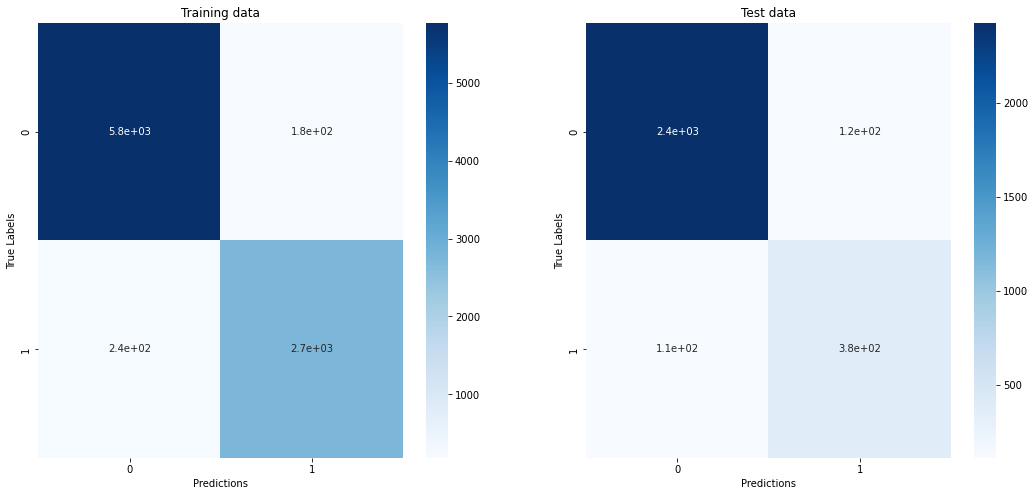

Training precision score: 0.9374
Test precision score: 0.7655
Training recall score: 0.9208
Test recall score: 0.7702
Training F1 score: 0.9290
Test F1 score: 0.7678


In [29]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pylab as plt

best_hparams = study.best_trial.params
print(best_hparams)
best_hparams_iterator = iter(study.best_trial.params)

n_layers = best_hparams[next(best_hparams_iterator)]

my_model = tf.keras.Sequential()
my_model.add(tf.keras.layers.InputLayer(input_shape = X_train.shape[1]))

for i in range(n_layers):
    num_hidden = best_hparams[next(best_hparams_iterator)]
    a_fun = best_hparams[next(best_hparams_iterator)]
    d_rate = best_hparams[next(best_hparams_iterator)]
    my_model.add(tf.keras.layers.Dense(num_hidden, activation = a_fun))
    my_model.add(tf.keras.layers.Dropout(d_rate))

my_model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

my_model.compile(loss = 'binary_crossentropy', optimizer = best_hparams['optimizer'])
my_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = best_hparams['callback_patience'])
my_model.fit(X_train_sm_s, y_train_sm, epochs = best_hparams['training_epochs'], validation_data = (X_test_s, y_test), callbacks = [my_callback], verbose = 0)

y_train_pred, y_test_pred = (my_model.predict(X_train_sm_s).flatten() > 0.5)*1, (my_model.predict(X_test_s).flatten() > 0.5) * 1

# let us take a look at the confusion matrix, predictions are 1 if the predicted proability for class 1 is higher than 0.5
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

train_cm = confusion_matrix(y_train_sm, y_train_pred)
sn.heatmap(train_cm, annot = True, cmap='Blues', ax = axs[0])

axs[0].set_xlabel('Predictions')
axs[0].set_ylabel('True Labels')
axs[0].set_title('Training data')

test_cm = confusion_matrix(y_test, y_test_pred)
sn.heatmap(test_cm, annot = True, cmap='Blues', ax = axs[1])

axs[1].set_xlabel('Predictions')
axs[1].set_ylabel('True Labels')
axs[1].set_title('Test data')

plt.show()

print(f'Training precision score: {precision_score(y_train_sm, y_train_pred):.4f}')
print(f'Test precision score: {precision_score(y_test, y_test_pred):.4f}')
print(f'Training recall score: {recall_score(y_train_sm, y_train_pred):.4f}')
print(f'Test recall score: {recall_score(y_test, y_test_pred):.4f}')
print(f'Training F1 score: {f1_score(y_train_sm, y_train_pred):.4f}')
print(f'Test F1 score: {f1_score(y_test, y_test_pred):.4f}')

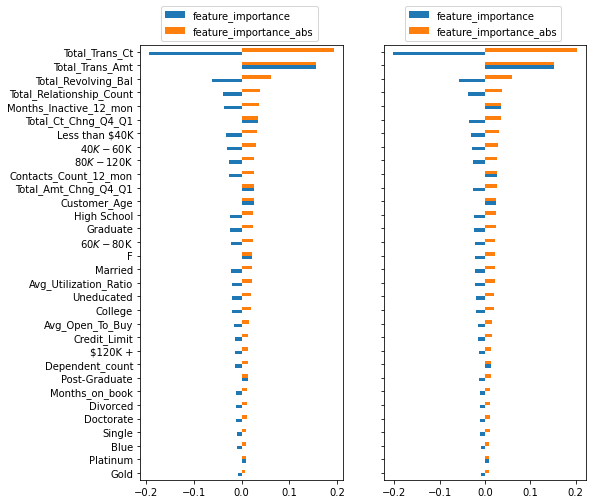

In [30]:
import numpy as np

fig, axs = plt.subplots(1, 2, figsize = (8, 8), sharey = True)

X_train_tensor = tf.convert_to_tensor(X_train_sm_s)
X_test_tensor = tf.convert_to_tensor(X_test_s)

with tf.GradientTape() as tape:
  tape.watch(X_train_tensor)
  y_train_pred = my_model(X_train_tensor)

grads = tape.gradient(y_train_pred, X_train_tensor).numpy()

feature_importance = np.sign(np.mean(grads, axis = 0)) * np.sqrt(np.mean(grads**2, axis = 0))
feature_importance_scaled = feature_importance / np.sum(np.abs(feature_importance))
feature_importance_df = pd.DataFrame(index = X_train.columns, data = feature_importance_scaled, columns = ['feature_importance'])
feature_importance_df.loc[:, 'feature_importance_abs'] = feature_importance_df.feature_importance.abs()
feature_importance_df.sort_values(by = 'feature_importance_abs', ascending = True, inplace = True)
feature_importance_df.plot.barh(ax = axs[0])

with tf.GradientTape() as tape:
  tape.watch(X_test_tensor)
  y_test_pred = my_model(X_test_tensor)

grads = tape.gradient(y_test_pred, X_test_tensor).numpy()

feature_importance = np.sign(np.mean(grads, axis = 0)) * np.sqrt(np.mean(grads**2, axis = 0))
feature_importance_scaled = feature_importance / np.sum(np.abs(feature_importance))
feature_importance_df = pd.DataFrame(index = X_train.columns, data = feature_importance_scaled, columns = ['feature_importance'])
feature_importance_df.loc[:, 'feature_importance_abs'] = feature_importance_df.feature_importance.abs()
feature_importance_df.sort_values(by = 'feature_importance_abs', ascending = True, inplace = True)
feature_importance_df.plot.barh(ax = axs[1])


axs[0].legend(bbox_to_anchor=(0.9, 1.1))
axs[1].legend(bbox_to_anchor=(0.9, 1.1))

In [31]:
import optuna
import tensorflow as tf
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
from sklearn.model_selection import KFold

def objective(trial):
  
  # check 1 up to 3 hidden layers 
  n_layers = trial.suggest_int('n_layers', 1, 3)

  # initialize an "empty" network
  my_model = tf.keras.Sequential()
  # we define a separate input layer which specifies the shape of feature variables
  my_model.add(tf.keras.layers.InputLayer(input_shape = X_train.shape[1]))

  # for each hidden layer
  for i in range(n_layers):
    # we search for an optimal amount of hidden neurons
    num_hidden = trial.suggest_int(f'n_units_l{i}', 4, 128, log=True)
    # and among the activation functions defined below
    a_fun = trial.suggest_categorical(f'a_fun_l{i}', ['tanh', 'sigmoid', 'relu'])  
    # add this hidden layer
    my_model.add(tf.keras.layers.Dense(num_hidden, activation = a_fun))
    # add dropout against overfitting
    dropout_rate = trial.suggest_float(f'drate_l{i}', 0.1, 0.5)
    my_model.add(tf.keras.layers.Dropout(dropout_rate))

  # in the end add an output to predict the housing value
  my_model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

  # and two optimizers
  optim = trial.suggest_categorical(f'optimizer', ['Adam', 'RMSprop'])

  # compile the model
  my_model.compile(loss = 'binary_crossentropy', optimizer = optim)

  # this step is important in my opinion, for each fold the network is supposed to train from scratch
  # this is why we save the initial parameters of the network and set them as a start once the network
  # is newly estimated for a new fold of the data
  init_weights = my_model.get_weights()

  # different callback parameters are available, we try the number of steps to wait for improvement of validation data
  # once the loss value for validation data does not improve for the number of patience steps the network optimization stops
  callback_patience = trial.suggest_int(f'callback_patience', 1, 5)
  my_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = callback_patience)

  # if the loss for validation data always improves, the model is trained until the maximum number of epochs is reached
  n_epochs = trial.suggest_int(f'training_epochs', 10, 100)
  
  f1_val = []

  # let us also optimize the number of folds
  kfold_splits = trial.suggest_int(f'kfolds', 2, 5)
  kfold = KFold(n_splits = kfold_splits, shuffle = True)

  for i, (train_index, val_index) in enumerate(kfold.split(X_train_sm_s)):
    X_train_fold, y_train_fold = X_train_sm_s[train_index], y_train_sm[train_index]
    X_val_fold, y_val_fold = X_train_sm_s[val_index], y_train_sm[val_index]

    my_model.set_weights(init_weights)
    my_model.fit(X_train_fold, y_train_fold, epochs = n_epochs, validation_data = (X_val_fold, y_val_fold), callbacks = [my_callback], verbose = 0)

  y_val_pred = (my_model.predict(X_val_fold).flatten() > 0.5)*1
  f1_val.append(f1_score(y_val_fold, y_val_pred))
  
  return np.mean(f1_val)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2022-11-28 09:31:09,851] A new study created in memory with name: no-name-2b09ee0c-995b-4259-bd65-8df5cf02b852


70/70 [==============================] - 0s 1ms/step


[I 2022-11-28 09:31:36,470] Trial 0 finished with value: 0.8187311178247735 and parameters: {'n_layers': 3, 'n_units_l0': 13, 'a_fun_l0': 'sigmoid', 'drate_l0': 0.13422022996185015, 'n_units_l1': 13, 'a_fun_l1': 'relu', 'drate_l1': 0.3343627105452283, 'n_units_l2': 13, 'a_fun_l2': 'tanh', 'drate_l2': 0.382537366319212, 'optimizer': 'Adam', 'callback_patience': 4, 'training_epochs': 12, 'kfolds': 4}. Best is trial 0 with value: 0.8187311178247735.


70/70 [==============================] - 0s 1ms/step


[I 2022-11-28 09:32:24,908] Trial 1 finished with value: 0.8266666666666668 and parameters: {'n_layers': 3, 'n_units_l0': 27, 'a_fun_l0': 'sigmoid', 'drate_l0': 0.48164058727532233, 'n_units_l1': 7, 'a_fun_l1': 'sigmoid', 'drate_l1': 0.47174576597439266, 'n_units_l2': 94, 'a_fun_l2': 'tanh', 'drate_l2': 0.31980316558616206, 'optimizer': 'Adam', 'callback_patience': 1, 'training_epochs': 97, 'kfolds': 4}. Best is trial 1 with value: 0.8266666666666668.


140/140 [==============================] - 0s 1ms/step


[I 2022-11-28 09:32:41,723] Trial 2 finished with value: 0.8150807899461401 and parameters: {'n_layers': 3, 'n_units_l0': 66, 'a_fun_l0': 'sigmoid', 'drate_l0': 0.19981449781112956, 'n_units_l1': 102, 'a_fun_l1': 'relu', 'drate_l1': 0.32065257946660797, 'n_units_l2': 5, 'a_fun_l2': 'tanh', 'drate_l2': 0.13580092756891485, 'optimizer': 'RMSprop', 'callback_patience': 1, 'training_epochs': 99, 'kfolds': 2}. Best is trial 1 with value: 0.8266666666666668.


70/70 [==============================] - 0s 1ms/step


[I 2022-11-28 09:33:51,704] Trial 3 finished with value: 0.8983164983164984 and parameters: {'n_layers': 1, 'n_units_l0': 74, 'a_fun_l0': 'tanh', 'drate_l0': 0.17300940744798948, 'optimizer': 'Adam', 'callback_patience': 5, 'training_epochs': 29, 'kfolds': 4}. Best is trial 3 with value: 0.8983164983164984.


140/140 [==============================] - 0s 2ms/step


[I 2022-11-28 09:35:14,808] Trial 4 finished with value: 0.8341810783316378 and parameters: {'n_layers': 2, 'n_units_l0': 17, 'a_fun_l0': 'sigmoid', 'drate_l0': 0.48348494161521727, 'n_units_l1': 106, 'a_fun_l1': 'sigmoid', 'drate_l1': 0.3815159832414051, 'optimizer': 'Adam', 'callback_patience': 5, 'training_epochs': 42, 'kfolds': 2}. Best is trial 3 with value: 0.8983164983164984.


140/140 [==============================] - 0s 1ms/step


[I 2022-11-28 09:36:19,754] Trial 5 finished with value: 0.8361227336122733 and parameters: {'n_layers': 2, 'n_units_l0': 41, 'a_fun_l0': 'sigmoid', 'drate_l0': 0.39567715168036055, 'n_units_l1': 41, 'a_fun_l1': 'sigmoid', 'drate_l1': 0.39987648615589033, 'optimizer': 'RMSprop', 'callback_patience': 4, 'training_epochs': 48, 'kfolds': 2}. Best is trial 3 with value: 0.8983164983164984.


56/56 [==============================] - 0s 1ms/step


[I 2022-11-28 09:37:32,413] Trial 6 finished with value: 0.8601583113456465 and parameters: {'n_layers': 1, 'n_units_l0': 9, 'a_fun_l0': 'relu', 'drate_l0': 0.38652518058178653, 'optimizer': 'Adam', 'callback_patience': 1, 'training_epochs': 74, 'kfolds': 5}. Best is trial 3 with value: 0.8983164983164984.


94/94 [==============================] - 0s 1ms/step


[I 2022-11-28 09:37:55,499] Trial 7 finished with value: 0.8263598326359832 and parameters: {'n_layers': 3, 'n_units_l0': 5, 'a_fun_l0': 'relu', 'drate_l0': 0.24392119433453835, 'n_units_l1': 8, 'a_fun_l1': 'sigmoid', 'drate_l1': 0.47131811845224625, 'n_units_l2': 8, 'a_fun_l2': 'sigmoid', 'drate_l2': 0.34660357630554217, 'optimizer': 'Adam', 'callback_patience': 2, 'training_epochs': 13, 'kfolds': 3}. Best is trial 3 with value: 0.8983164983164984.


56/56 [==============================] - 0s 1ms/step


[I 2022-11-28 09:38:39,780] Trial 8 finished with value: 0.833759590792839 and parameters: {'n_layers': 1, 'n_units_l0': 5, 'a_fun_l0': 'tanh', 'drate_l0': 0.10650690549861036, 'optimizer': 'RMSprop', 'callback_patience': 1, 'training_epochs': 60, 'kfolds': 5}. Best is trial 3 with value: 0.8983164983164984.


56/56 [==============================] - 0s 2ms/step


[I 2022-11-28 09:42:01,837] Trial 9 finished with value: 0.9036658141517477 and parameters: {'n_layers': 3, 'n_units_l0': 102, 'a_fun_l0': 'sigmoid', 'drate_l0': 0.11855448757979628, 'n_units_l1': 58, 'a_fun_l1': 'relu', 'drate_l1': 0.10892311526291608, 'n_units_l2': 8, 'a_fun_l2': 'sigmoid', 'drate_l2': 0.34039598323274467, 'optimizer': 'Adam', 'callback_patience': 4, 'training_epochs': 83, 'kfolds': 5}. Best is trial 9 with value: 0.9036658141517477.


56/56 [==============================] - 0s 2ms/step


[I 2022-11-28 09:44:14,693] Trial 10 finished with value: 0.9159034138218152 and parameters: {'n_layers': 2, 'n_units_l0': 106, 'a_fun_l0': 'tanh', 'drate_l0': 0.28680210280927354, 'n_units_l1': 32, 'a_fun_l1': 'tanh', 'drate_l1': 0.10268903929450413, 'optimizer': 'Adam', 'callback_patience': 3, 'training_epochs': 77, 'kfolds': 5}. Best is trial 10 with value: 0.9159034138218152.


56/56 [==============================] - 0s 1ms/step


[I 2022-11-28 09:45:52,127] Trial 11 finished with value: 0.9083333333333333 and parameters: {'n_layers': 2, 'n_units_l0': 112, 'a_fun_l0': 'tanh', 'drate_l0': 0.27867317111517403, 'n_units_l1': 34, 'a_fun_l1': 'tanh', 'drate_l1': 0.11055563882573582, 'optimizer': 'Adam', 'callback_patience': 3, 'training_epochs': 78, 'kfolds': 5}. Best is trial 10 with value: 0.9159034138218152.


56/56 [==============================] - 0s 2ms/step


[I 2022-11-28 09:47:29,024] Trial 12 finished with value: 0.9152810768012668 and parameters: {'n_layers': 2, 'n_units_l0': 104, 'a_fun_l0': 'tanh', 'drate_l0': 0.2982926819202772, 'n_units_l1': 24, 'a_fun_l1': 'tanh', 'drate_l1': 0.13947729130082331, 'optimizer': 'Adam', 'callback_patience': 3, 'training_epochs': 68, 'kfolds': 5}. Best is trial 10 with value: 0.9159034138218152.


94/94 [==============================] - 0s 1ms/step


[I 2022-11-28 09:49:17,391] Trial 13 finished with value: 0.8856569709127382 and parameters: {'n_layers': 2, 'n_units_l0': 48, 'a_fun_l0': 'tanh', 'drate_l0': 0.34575750027940755, 'n_units_l1': 20, 'a_fun_l1': 'tanh', 'drate_l1': 0.1963964451774547, 'optimizer': 'Adam', 'callback_patience': 3, 'training_epochs': 65, 'kfolds': 3}. Best is trial 10 with value: 0.9159034138218152.


70/70 [==============================] - 0s 2ms/step


[I 2022-11-28 09:50:23,718] Trial 14 finished with value: 0.8938401048492791 and parameters: {'n_layers': 2, 'n_units_l0': 126, 'a_fun_l0': 'tanh', 'drate_l0': 0.3140115172779779, 'n_units_l1': 19, 'a_fun_l1': 'tanh', 'drate_l1': 0.21274610810671946, 'optimizer': 'RMSprop', 'callback_patience': 2, 'training_epochs': 85, 'kfolds': 4}. Best is trial 10 with value: 0.9159034138218152.


56/56 [==============================] - 0s 1ms/step


[I 2022-11-28 09:52:11,685] Trial 15 finished with value: 0.8613013698630136 and parameters: {'n_layers': 2, 'n_units_l0': 30, 'a_fun_l0': 'tanh', 'drate_l0': 0.2562561396361379, 'n_units_l1': 4, 'a_fun_l1': 'tanh', 'drate_l1': 0.1923042154000737, 'optimizer': 'Adam', 'callback_patience': 2, 'training_epochs': 67, 'kfolds': 5}. Best is trial 10 with value: 0.9159034138218152.


56/56 [==============================] - 0s 1ms/step


[I 2022-11-28 09:54:27,504] Trial 16 finished with value: 0.8678260869565217 and parameters: {'n_layers': 1, 'n_units_l0': 63, 'a_fun_l0': 'tanh', 'drate_l0': 0.34056178098687895, 'optimizer': 'Adam', 'callback_patience': 3, 'training_epochs': 52, 'kfolds': 5}. Best is trial 10 with value: 0.9159034138218152.


94/94 [==============================] - 0s 1ms/step


[I 2022-11-28 09:55:15,526] Trial 17 finished with value: 0.90245174752217 and parameters: {'n_layers': 2, 'n_units_l0': 41, 'a_fun_l0': 'relu', 'drate_l0': 0.20654793009702194, 'n_units_l1': 33, 'a_fun_l1': 'tanh', 'drate_l1': 0.16551028028868764, 'optimizer': 'Adam', 'callback_patience': 4, 'training_epochs': 37, 'kfolds': 3}. Best is trial 10 with value: 0.9159034138218152.


70/70 [==============================] - 0s 2ms/step


[I 2022-11-28 09:56:14,409] Trial 18 finished with value: 0.8759322033898305 and parameters: {'n_layers': 2, 'n_units_l0': 85, 'a_fun_l0': 'tanh', 'drate_l0': 0.41940444994452164, 'n_units_l1': 57, 'a_fun_l1': 'tanh', 'drate_l1': 0.25712054968452913, 'optimizer': 'RMSprop', 'callback_patience': 2, 'training_epochs': 88, 'kfolds': 4}. Best is trial 10 with value: 0.9159034138218152.


56/56 [==============================] - 0s 1ms/step


[I 2022-11-28 09:59:05,905] Trial 19 finished with value: 0.8975021533161067 and parameters: {'n_layers': 1, 'n_units_l0': 24, 'a_fun_l0': 'tanh', 'drate_l0': 0.29352532517920743, 'optimizer': 'Adam', 'callback_patience': 3, 'training_epochs': 70, 'kfolds': 5}. Best is trial 10 with value: 0.9159034138218152.


{'n_layers': 2, 'n_units_l0': 106, 'a_fun_l0': 'tanh', 'drate_l0': 0.28680210280927354, 'n_units_l1': 32, 'a_fun_l1': 'tanh', 'drate_l1': 0.10268903929450413, 'optimizer': 'Adam', 'callback_patience': 3, 'training_epochs': 77, 'kfolds': 5}
95/95 [==============================] - 0s 2ms/step


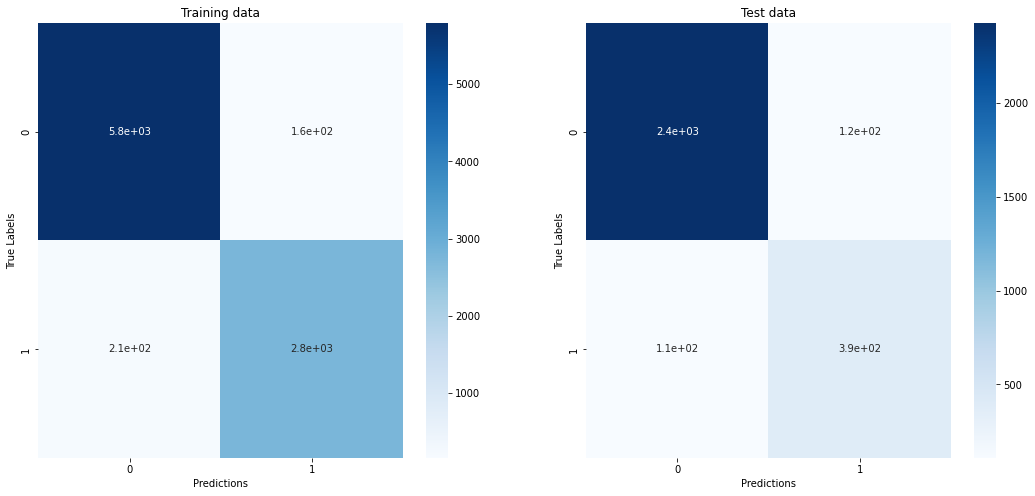

Training precision score: 0.9440
Test precision score: 0.7679
Training recall score: 0.9281
Test recall score: 0.7802
Training F1 score: 0.9360
Test F1 score: 0.7740


In [32]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pylab as plt

best_hparams = study.best_trial.params
print(best_hparams)
best_hparams_iterator = iter(study.best_trial.params)

n_layers = best_hparams[next(best_hparams_iterator)]

my_model = tf.keras.Sequential()
my_model.add(tf.keras.layers.InputLayer(input_shape = X_train.shape[1]))

for i in range(n_layers):
    num_hidden = best_hparams[next(best_hparams_iterator)]
    a_fun = best_hparams[next(best_hparams_iterator)]
    d_rate = best_hparams[next(best_hparams_iterator)]
    my_model.add(tf.keras.layers.Dense(num_hidden, activation = a_fun))
    my_model.add(tf.keras.layers.Dropout(d_rate))

my_model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

my_model.compile(loss = 'binary_crossentropy', optimizer = best_hparams['optimizer'])
my_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = best_hparams['callback_patience'])
my_model.fit(X_train_sm_s, y_train_sm, epochs = best_hparams['training_epochs'], validation_data = (X_test_s, y_test), callbacks = [my_callback], verbose = 0)

y_train_pred, y_test_pred = (my_model.predict(X_train_sm_s).flatten() > 0.5)*1, (my_model.predict(X_test_s).flatten() > 0.5) * 1

# let us take a look at the confusion matrix, predictions are 1 if the predicted proability for class 1 is higher than 0.5
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

train_cm = confusion_matrix(y_train_sm, y_train_pred)
sn.heatmap(train_cm, annot = True, cmap='Blues', ax = axs[0])

axs[0].set_xlabel('Predictions')
axs[0].set_ylabel('True Labels')
axs[0].set_title('Training data')

test_cm = confusion_matrix(y_test, y_test_pred)
sn.heatmap(test_cm, annot = True, cmap='Blues', ax = axs[1])

axs[1].set_xlabel('Predictions')
axs[1].set_ylabel('True Labels')
axs[1].set_title('Test data')

plt.show()

print(f'Training precision score: {precision_score(y_train_sm, y_train_pred):.4f}')
print(f'Test precision score: {precision_score(y_test, y_test_pred):.4f}')
print(f'Training recall score: {recall_score(y_train_sm, y_train_pred):.4f}')
print(f'Test recall score: {recall_score(y_test, y_test_pred):.4f}')
print(f'Training F1 score: {f1_score(y_train_sm, y_train_pred):.4f}')
print(f'Test F1 score: {f1_score(y_test, y_test_pred):.4f}')

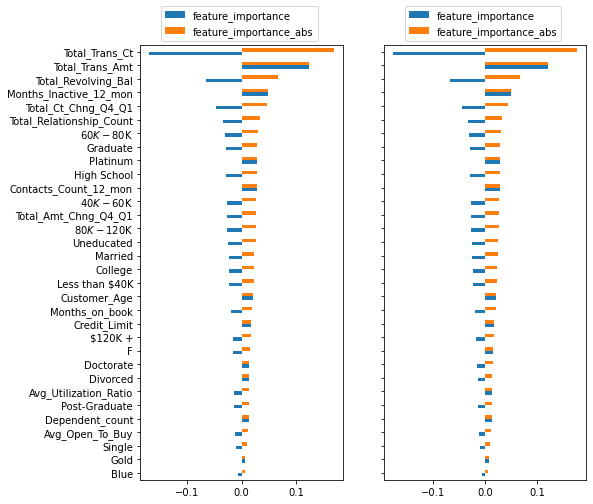

In [33]:
import numpy as np

fig, axs = plt.subplots(1, 2, figsize = (8, 8), sharey = True)

X_train_tensor = tf.convert_to_tensor(X_train_sm_s)
X_test_tensor = tf.convert_to_tensor(X_test_s)

with tf.GradientTape() as tape:
  tape.watch(X_train_tensor)
  y_train_pred = my_model(X_train_tensor)

grads = tape.gradient(y_train_pred, X_train_tensor).numpy()

feature_importance = np.sign(np.mean(grads, axis = 0)) * np.sqrt(np.mean(grads**2, axis = 0))
feature_importance_scaled = feature_importance / np.sum(np.abs(feature_importance))
feature_importance_df = pd.DataFrame(index = X_train.columns, data = feature_importance_scaled, columns = ['feature_importance'])
feature_importance_df.loc[:, 'feature_importance_abs'] = feature_importance_df.feature_importance.abs()
feature_importance_df.sort_values(by = 'feature_importance_abs', ascending = True, inplace = True)
feature_importance_df.plot.barh(ax = axs[0])

with tf.GradientTape() as tape:
  tape.watch(X_test_tensor)
  y_test_pred = my_model(X_test_tensor)

grads = tape.gradient(y_test_pred, X_test_tensor).numpy()

feature_importance = np.sign(np.mean(grads, axis = 0)) * np.sqrt(np.mean(grads**2, axis = 0))
feature_importance_scaled = feature_importance / np.sum(np.abs(feature_importance))
feature_importance_df = pd.DataFrame(index = X_train.columns, data = feature_importance_scaled, columns = ['feature_importance'])
feature_importance_df.loc[:, 'feature_importance_abs'] = feature_importance_df.feature_importance.abs()
feature_importance_df.sort_values(by = 'feature_importance_abs', ascending = True, inplace = True)
feature_importance_df.plot.barh(ax = axs[1])


axs[0].legend(bbox_to_anchor=(0.9, 1.1))
axs[1].legend(bbox_to_anchor=(0.9, 1.1))